In [2]:
%matplotlib notebook
%matplotlib inline

import os
from packaging import version
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})


# Below plots are based on Tensorboard logs (not based on every iteration)

## Uncomment this in case csv files are not available

# Below plots are based on .pkl files as they are plotted based on each iteration

In [3]:
import pandas as pd
import numpy as np
import torch
from matplotlib.colors import ListedColormap
plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})

cmap = sns.color_palette("rocket_r", as_cmap=True)
_cmap = sns.color_palette("rocket", as_cmap=True)

softmatch = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/reset32_scaler_4_d3b0e90.pkl') # best_st_plot_60c84b7
softmatch_weights = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_0.5.pkl')
iou3d = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_baseline.pkl') # iou_metrics_baseline_bs8_split_1_1_trial_1_d16ba20
# iou3d = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/3diou.pkl') # iou_metrics_baseline_bs8_split_1_1_trial_1_d16ba20
iou3d_old_thresh = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/iou3d_old_thresh2.pkl') 
# This is based on FG+UC+BG with class agnostic local thresholds , it needs a re-run to get the correct class agnostic scores based on UC_FP+BG
# ablation1_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_ablation1.pkl') 
# ablation1_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/a8_scores.pkl') 
# ablation1_df = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_var_nan.pkl') 


# df2 =  pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_var_nan.pkl')
# scores_6 = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_6.pkl')


#### Generating TP and FP based on 3diouMatch Threshold FG = 0.75

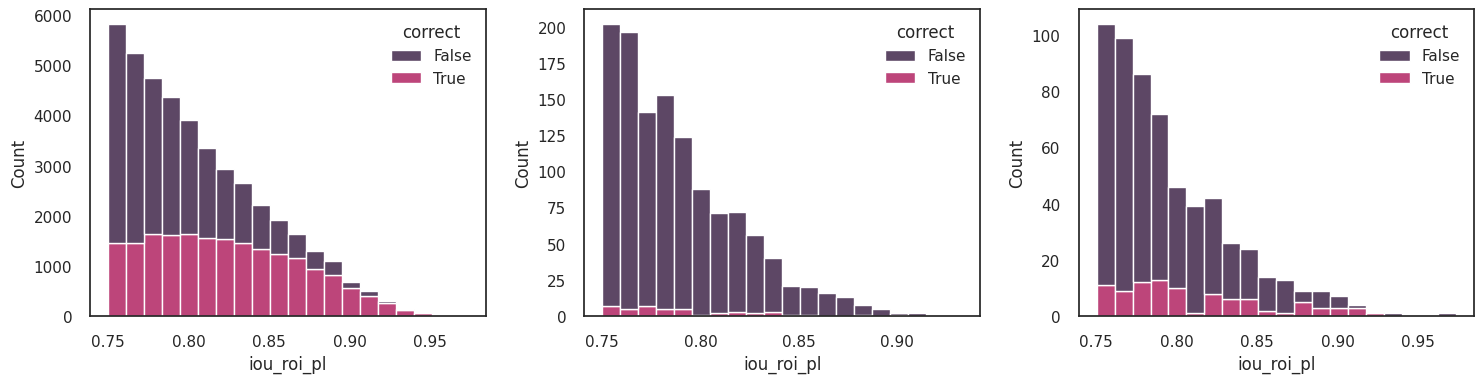

In [4]:
scores = {
    'iou_roi_gt': iou3d['iou_roi_gt'],
    'iou_roi_pl': iou3d['iou_roi_pl'],
    'iteration' : iou3d['iteration'],
    'class_labels': iou3d['class_labels'],
    'pred_scores': iou3d['pred_scores']
}
thresh_3diou = pd.DataFrame(scores)
thresh_3diou['correct'] = (thresh_3diou['iou_roi_gt'] > 0.75) & (thresh_3diou['iou_roi_pl'] > 0.75)
thresh_3diou['filtered_wrt_pl'] = (thresh_3diou['iou_roi_pl'] > 0.75)
filtered_thresh_df = thresh_3diou[thresh_3diou['filtered_wrt_pl'] == True]
scores_cls = []
p = sns.color_palette('rocket')
palette = [p[0],p[2]]
f, axes = plt.subplots(1,3, figsize=(15,4))
for i in range(0,3):
    # thresh_3diou['correct'] = (thresh_3diou['iou_roi_gt'] >= 0.50) & (thresh_3diou['iou_roi_pl'] >= 0.50)
    mask = (thresh_3diou['class_labels'] == i+1) & (thresh_3diou['iou_roi_pl'] >= 0.75) 
    scores_cls.append(thresh_3diou[mask])
    sns.histplot(ax=axes[i],data=scores_cls[i], x="iou_roi_pl",hue='correct',fill=True, kde=False,stat='count',multiple="stack",legend=True, bins=20, palette=palette, alpha=0.8)
    #sns.lineplot(ax=axes[i],data=scores_cls[i], x=thresh_3diou.index,y="correct",palette=palette, alpha=0.8)
    f.tight_layout()
    f.subplots_adjust(wspace=0.25, hspace=0.2)
    f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
plt.show()

In [5]:
thresh_3diou['pred_scores']

0           1.080634
1          10.418470
2           0.404545
3           0.847471
4          -1.530079
             ...    
1412091    -3.424217
1412092   -10.724598
1412093    -2.249504
1412094    -9.197587
1412095    -0.692683
Name: pred_scores, Length: 1412096, dtype: float64

In [7]:
# watch out normalized only if not. 
values = torch.tensor(iou3d['pred_scores'],device='cuda')
values = values.sigmoid()
iou3d['pred_scores'] = values.tolist()

In [8]:
scores = {
    'iou_roi_gt': iou3d['iou_roi_gt'],
    'iou_roi_pl': iou3d['iou_roi_pl'],
    'iteration' : iou3d['iteration'],
    'class_labels': iou3d['class_labels'],
    'pred_scores': iou3d['pred_scores'],
}
iou3d_df = pd.DataFrame(scores)

In [9]:
threshold = 0.65
iou3d_df['threshold'] = threshold
iou3d_df['epoch'] = (iou3d_df['iteration']) // 24 + 1
iou3d_df['correct'] = (iou3d_df['iou_roi_pl'] >= threshold) & (iou3d_df['iou_roi_gt'] >= threshold)
iou3d_df['correct_pred'] = (iou3d_df['pred_scores'] >= threshold) & (iou3d_df['iou_roi_gt'] >= threshold)
iou3d_df['fg_wrt_gt'] = (iou3d_df['iou_roi_gt'] >= threshold)
grouped_df = iou3d_df.groupby('epoch')

# Plot Epochwise correspondance of 3dIOUMatch(with changed sem,global thresholds) with GTs 

#### Epoch 1-5

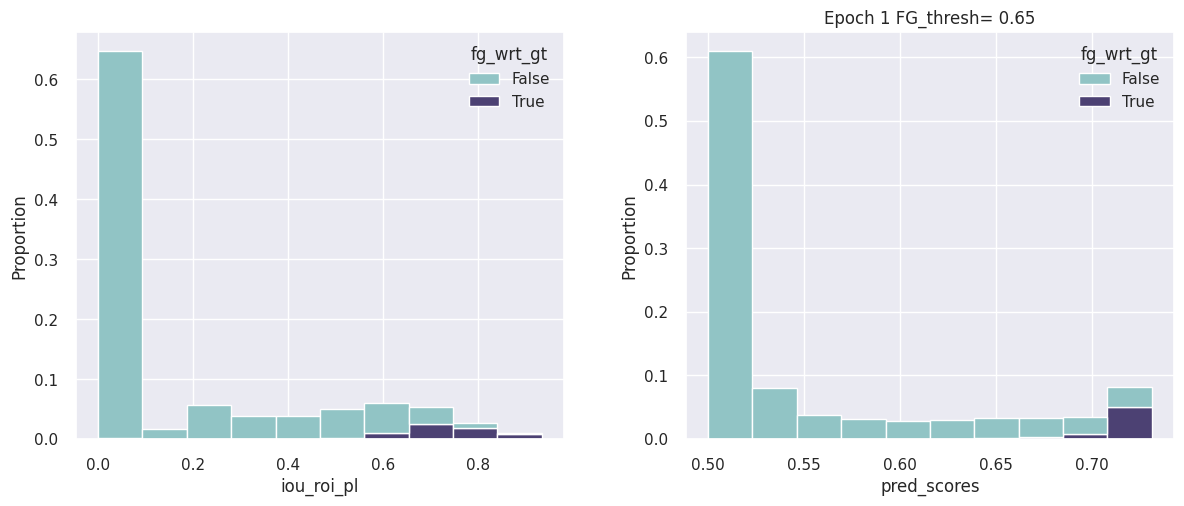

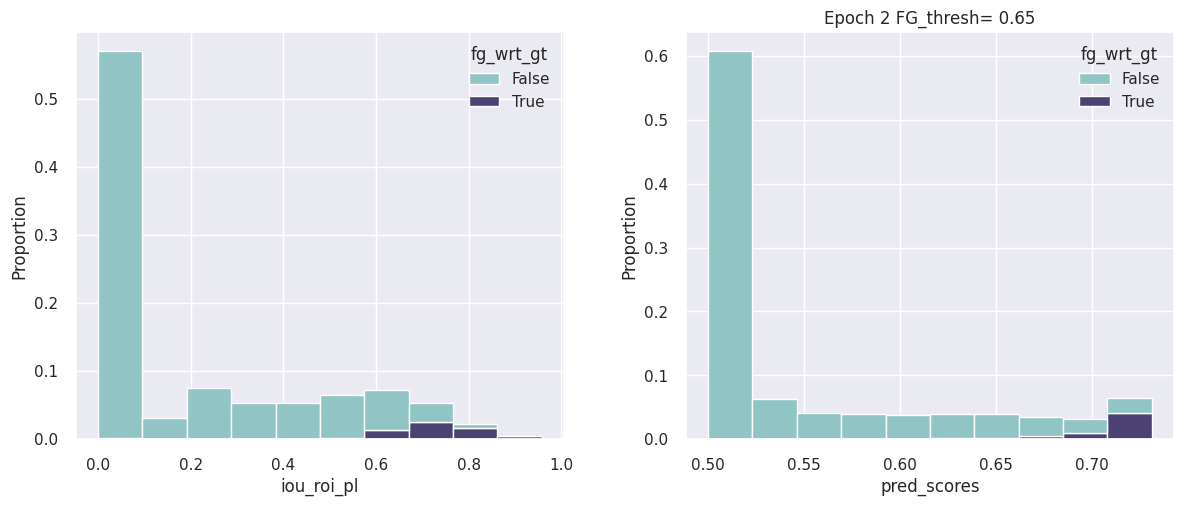

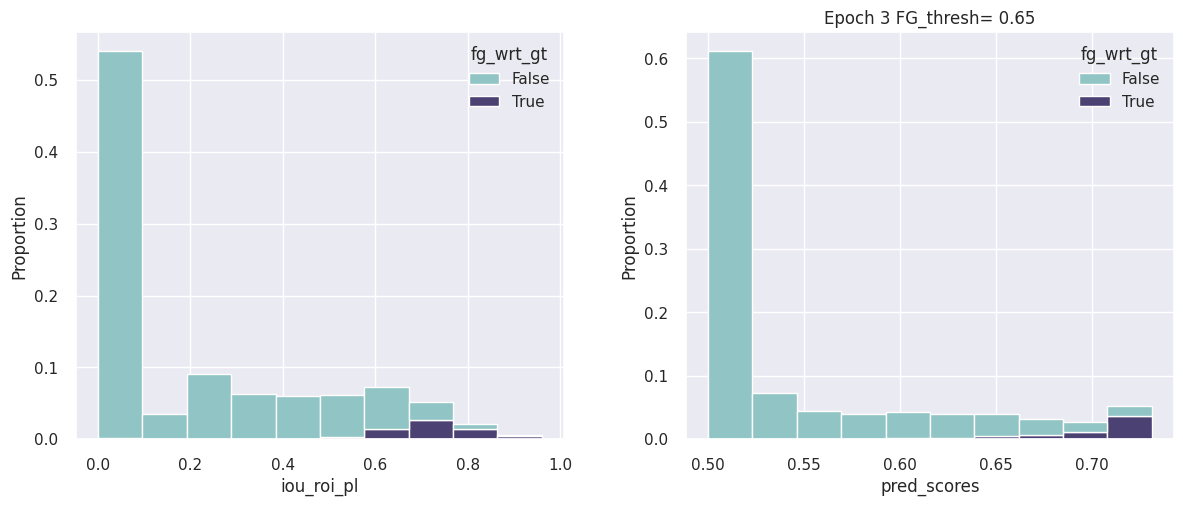

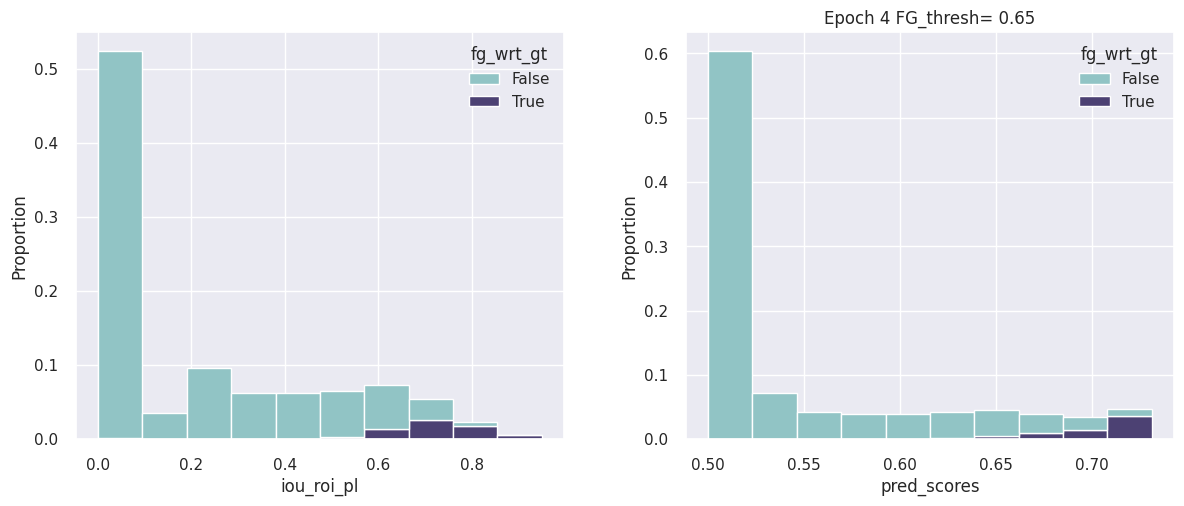

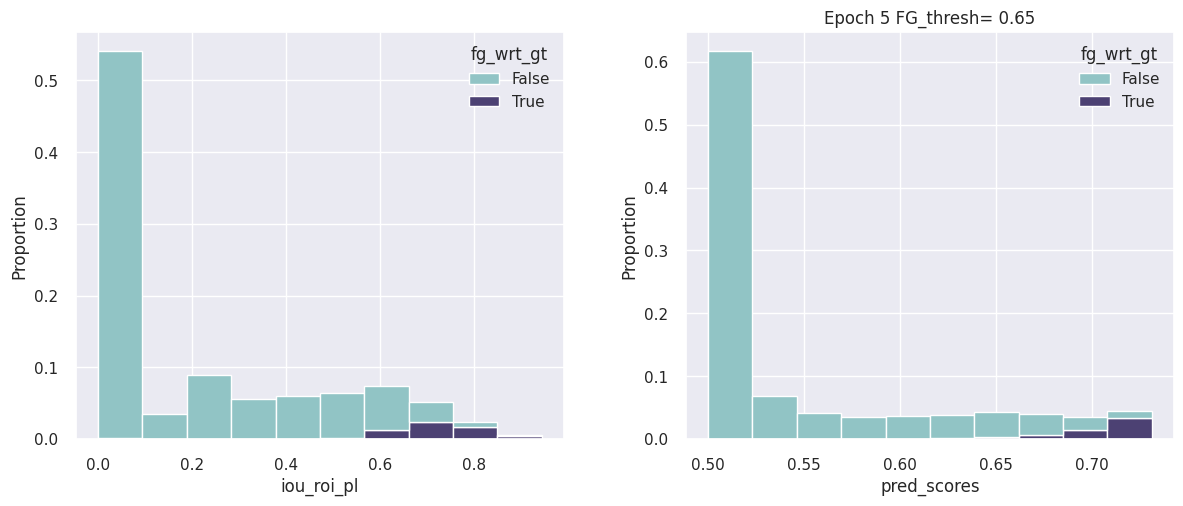

In [10]:
def plot_corres_gt(grouped_df,start,end):
    start = 1
    end = 6
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='darkgrid')
    # for i in range(0,3):
    for i in range(start,end):
        f, axes = plt.subplots(1,2, figsize=(12,5))
        sns.histplot(ax=axes[0],data=grouped_df.get_group(float(i)),x='iou_roi_pl',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=10,fill=True,legend=True,palette=palette,alpha=1.0)
        sns.histplot(ax=axes[1],data=grouped_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',fill=True,bins=10,palette=palette,alpha=1.0)
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        plt.title(f'Epoch {i} FG_thresh= {threshold}')
    f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    plt.show()
plot_corres_gt(grouped_df,start=1,end=5)

#### Epochs 40-45

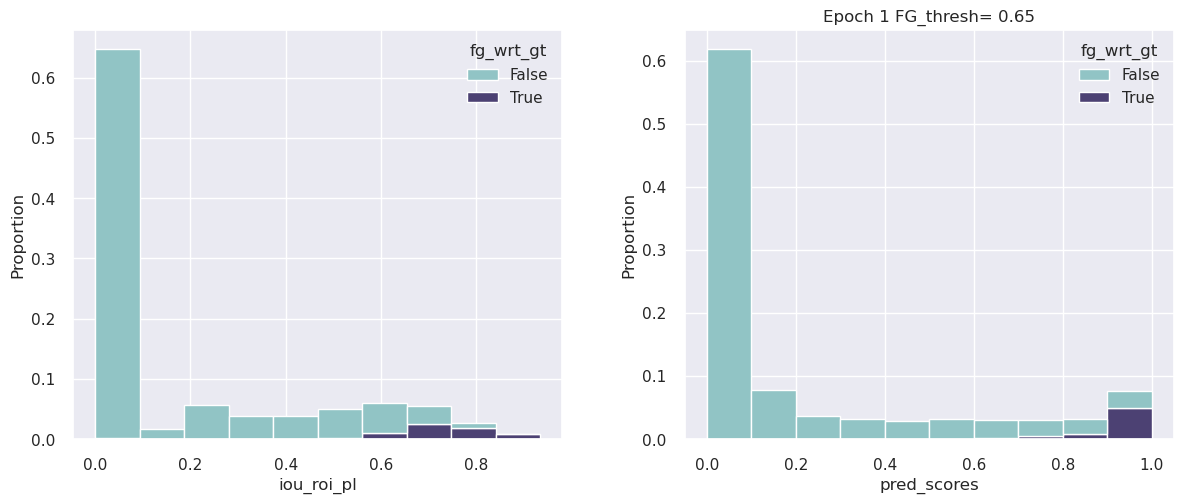

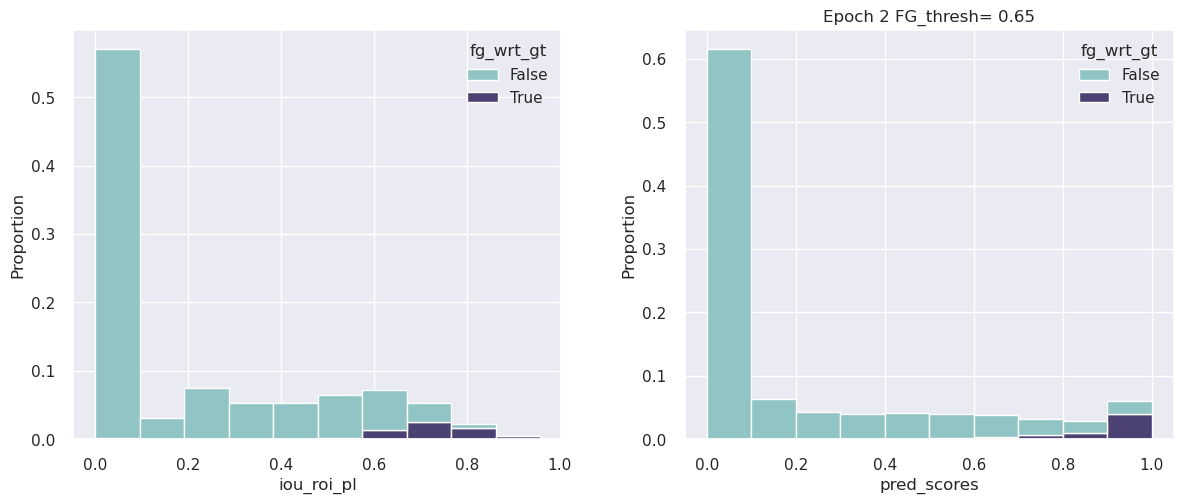

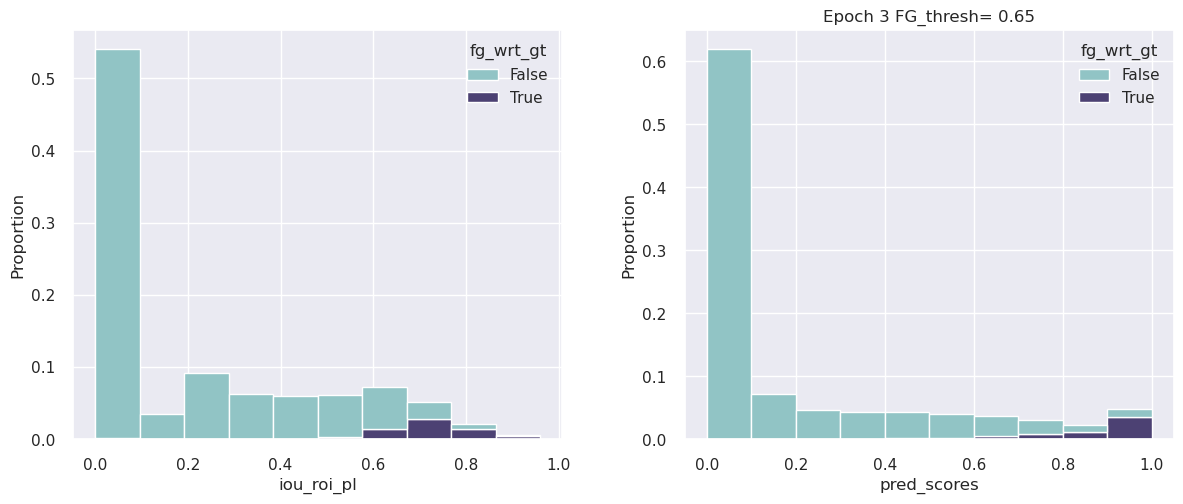

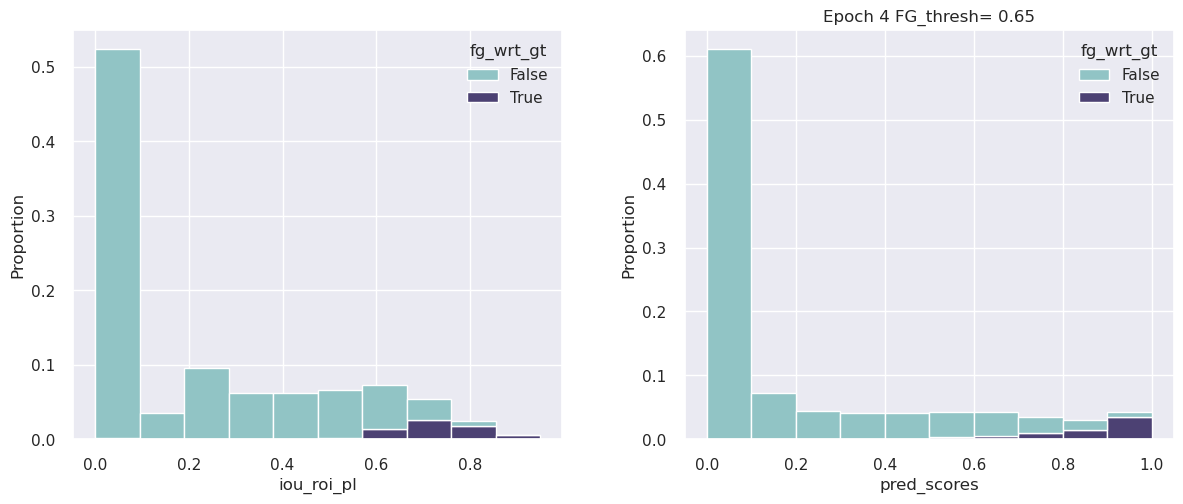

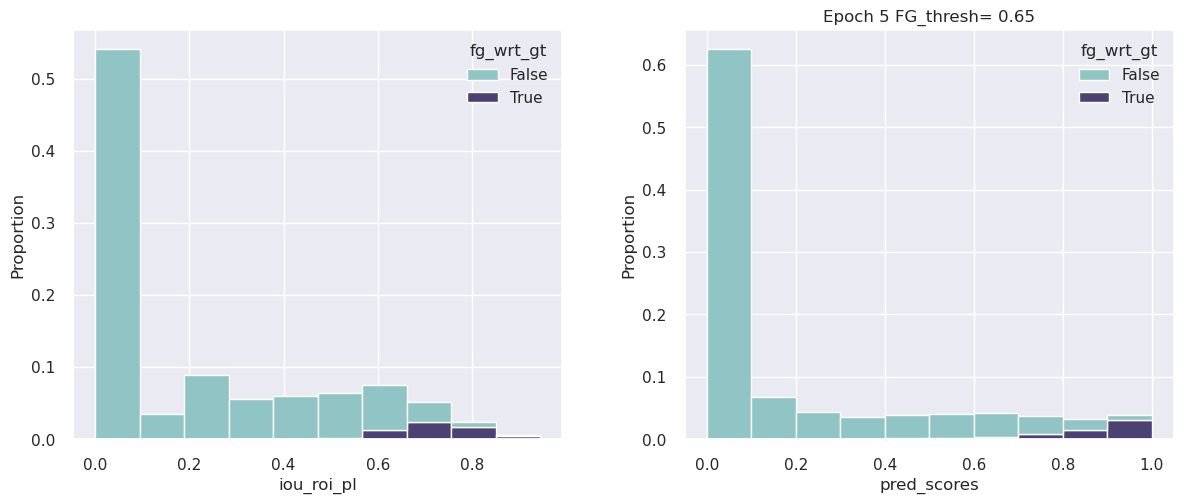

In [67]:
plot_corres_gt(grouped_df,start=40,end=45)

In [11]:
threshold = 0.60
scores = {
    'iou_roi_gt': iou3d_old_thresh['iou_roi_gt'],
    'iou_roi_pl': iou3d_old_thresh['iou_roi_pl'],
    'iteration' : iou3d_old_thresh['iteration'],
    'class_labels': iou3d_old_thresh['class_labels'],
    'pred_scores': iou3d_old_thresh['pred_scores'],
    'threshold': threshold,
    'roi_scores': iou3d_old_thresh['roi_scores']
}
iou3d_ot_df = pd.DataFrame(scores)

In [12]:
iou3d_ot_df.head()

,iou_roi_gt,iou_roi_pl,iteration,class_labels,pred_scores,threshold,roi_scores
0,0.594777,0.697189,0.0,1,0.924146,0.6,0.036497
1,0.686190,0.640282,0.0,1,0.880578,0.6,0.043485
2,0.000000,0.721479,0.0,1,0.771008,0.6,0.829503
3,0.000000,0.742094,0.0,2,0.814994,0.6,0.491779
4,0.000000,0.570624,0.0,1,0.601770,0.6,0.057287


In [13]:
iou3d_ot_df['threshold'] = threshold
iou3d_ot_df['epoch'] = (iou3d_ot_df['iteration']) // 24 + 1
iou3d_ot_df['correct'] = (iou3d_ot_df['iou_roi_pl'] >= threshold) & (iou3d_ot_df['iou_roi_gt'] >= threshold)
iou3d_ot_df['fg_wrt_gt'] = (iou3d_ot_df['iou_roi_gt'] >= threshold)
grouped_ot_df = iou3d_ot_df.groupby('epoch')

# Plot of correspondance of 3dIOUMatch with default thresholds as in Paper

#### Epochs 1 - 5

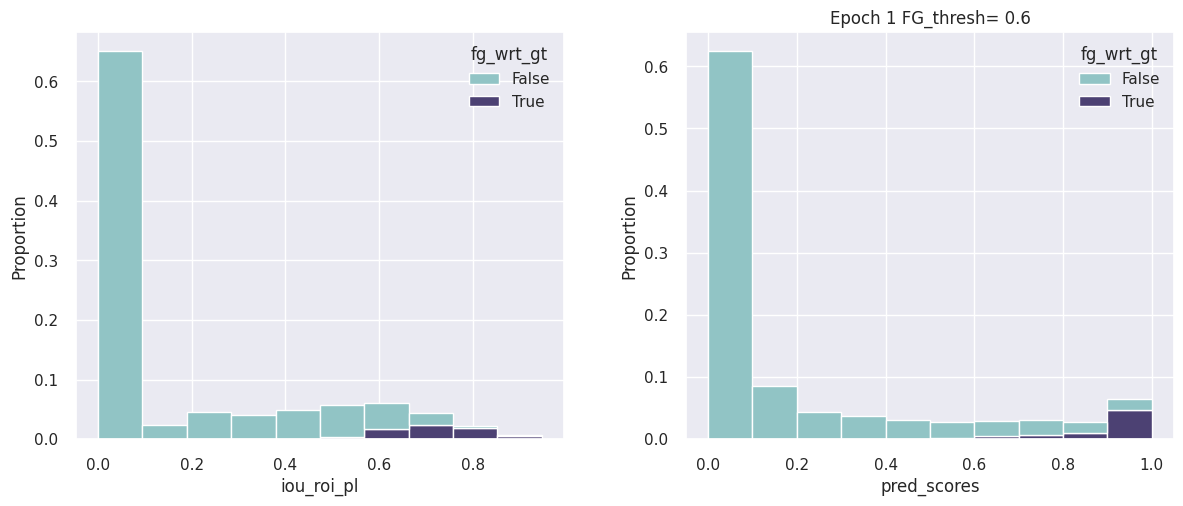

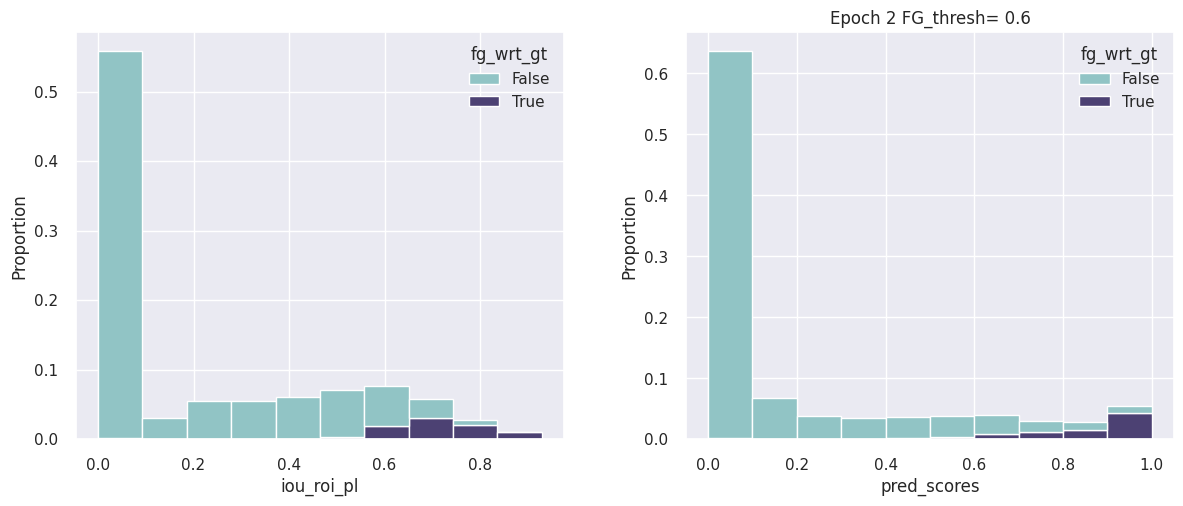

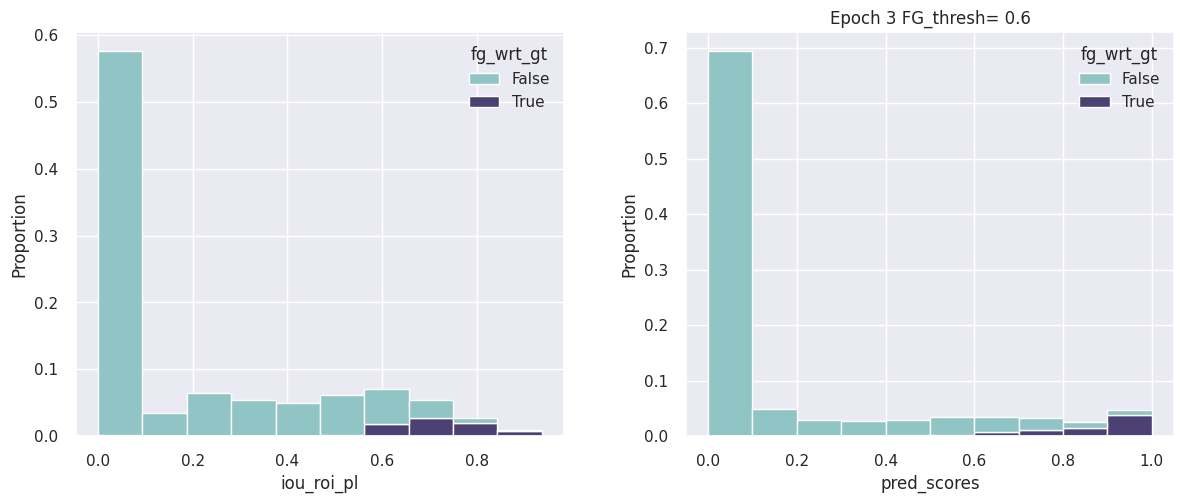

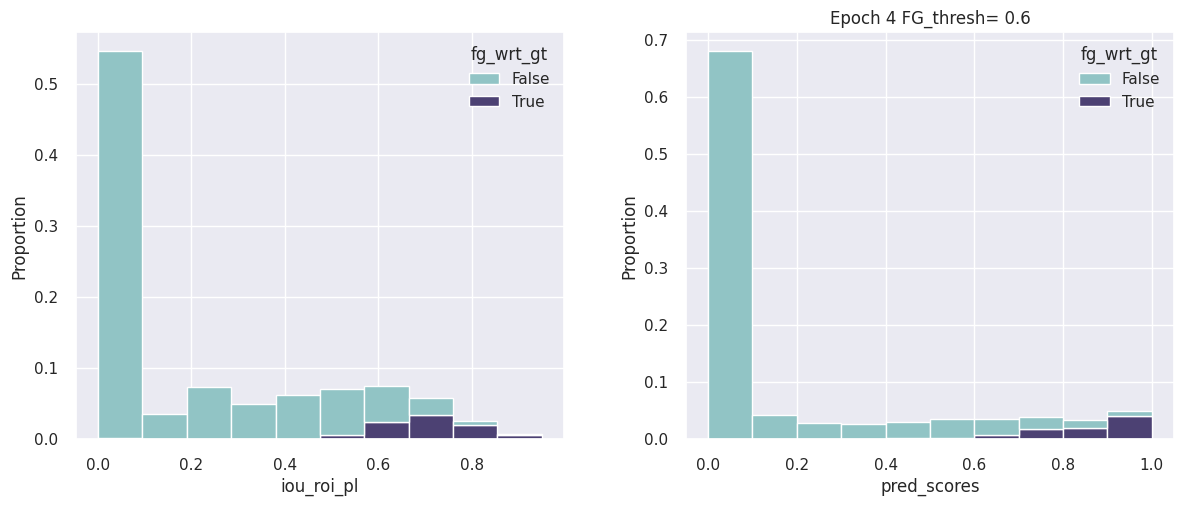

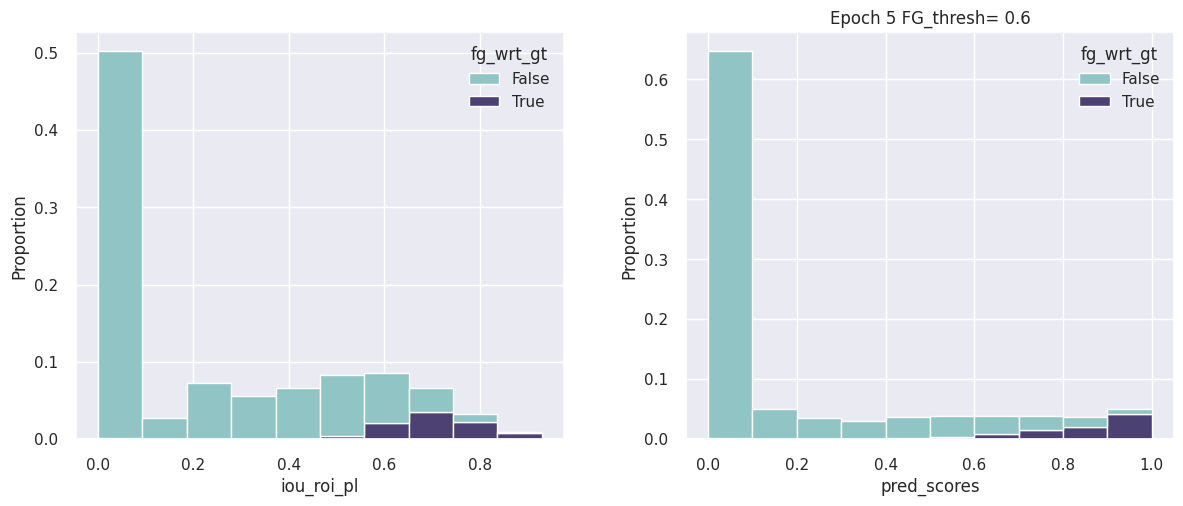

In [14]:
plot_corres_gt(grouped_ot_df,start=1,end=5)

#### Epoch 45-50

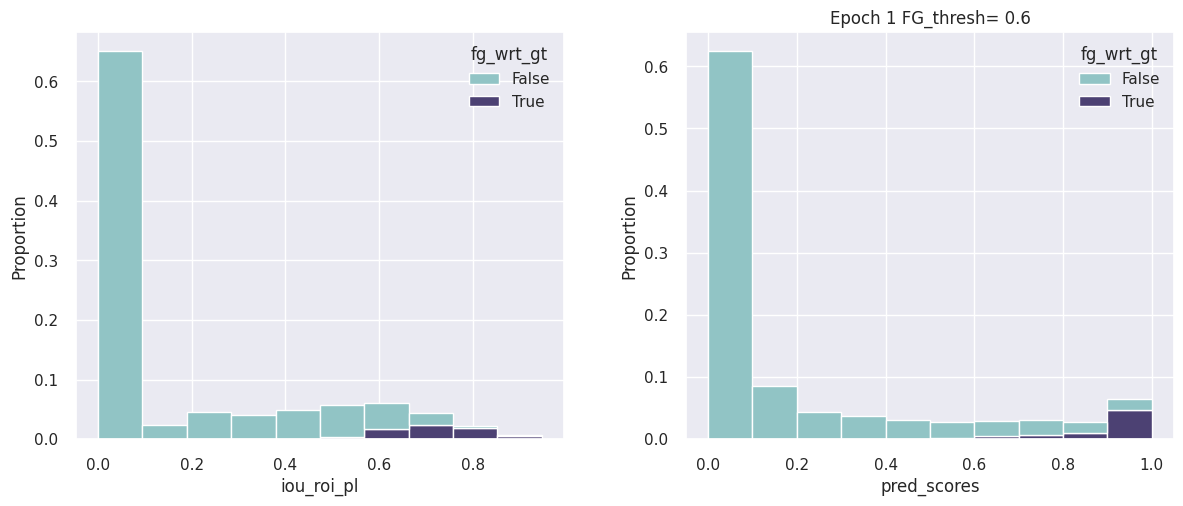

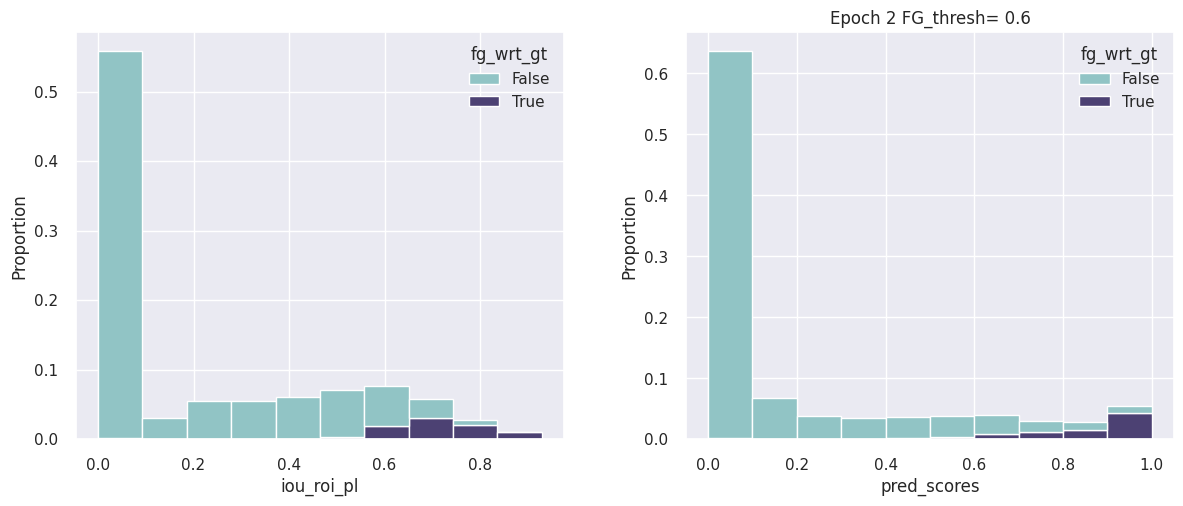

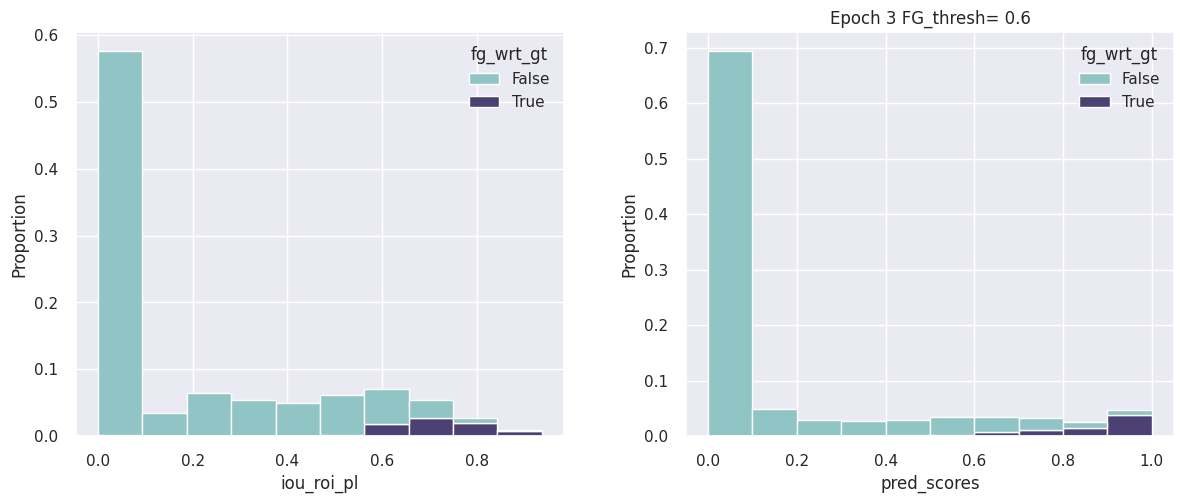

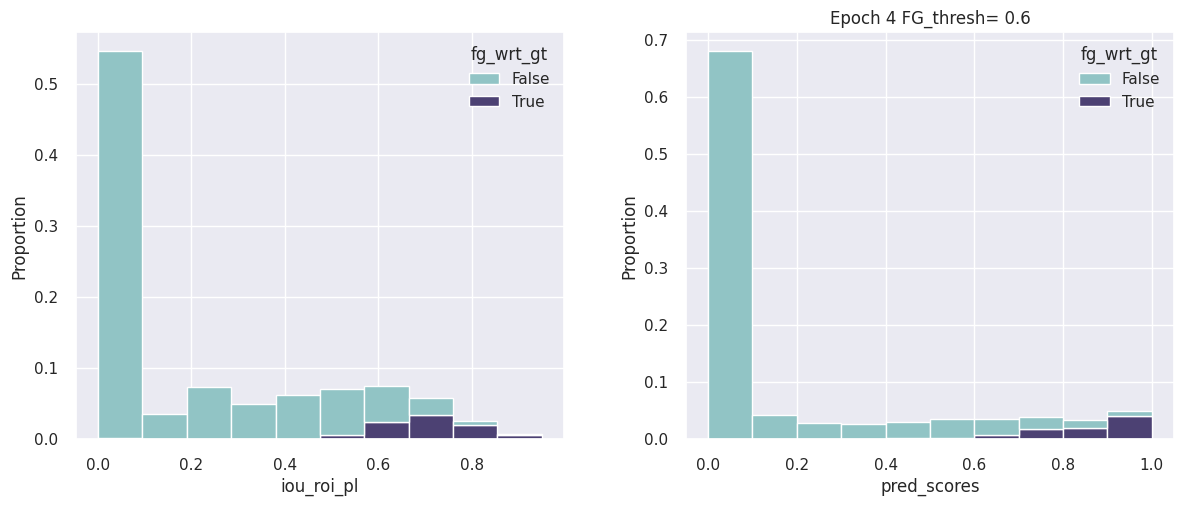

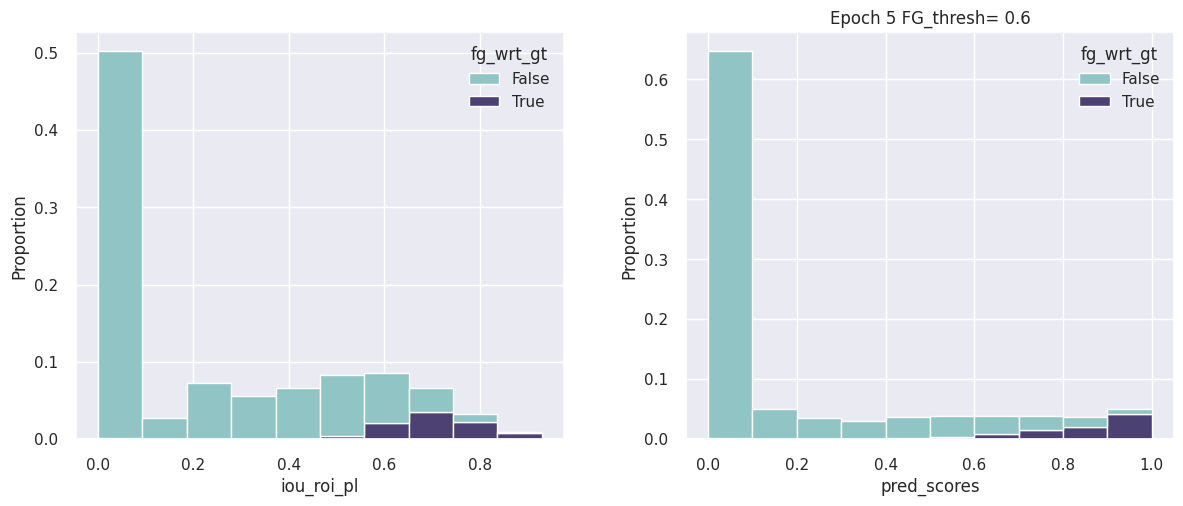

In [15]:
plot_corres_gt(grouped_ot_df,45,50)

#### Zoomed in Visualization

In [16]:
# to visualize in terms of iou
iou3d_ot_iou_df = iou3d_ot_df[iou3d_ot_df['iou_roi_pl']>= 0.25]
grouped_ot_iou_df = iou3d_ot_iou_df.groupby('epoch')
# only sees the pred values above 0.25 for better visualization
iou3d_ot_df['pred_bins'] = iou3d_ot_iou_df['pred_scores'].apply(lambda x: round(x,1))
iou3d_ot_pred_df = iou3d_ot_df[iou3d_ot_df['pred_scores']>= 0.25]
grouped_ot_pred_df = iou3d_ot_pred_df.groupby('epoch')

In [17]:
iou3d_ot_pred_car_df = iou3d_ot_df[(iou3d_ot_df['pred_scores']>= 0.25) & (iou3d_ot_df['class_labels'] == 1)]
iou3d_ot_pred_ped_df = iou3d_ot_df[(iou3d_ot_df['pred_scores']>= 0.25) & (iou3d_ot_df['class_labels'] == 2)]
iou3d_ot_pred_cyc_df = iou3d_ot_df[(iou3d_ot_df['pred_scores']>= 0.25) & (iou3d_ot_df['class_labels'] == 3)]
grouped_ot_pred_car_df = iou3d_ot_pred_car_df.groupby('epoch')
grouped_ot_pred_ped_df = iou3d_ot_pred_ped_df.groupby('epoch')
grouped_ot_pred_cyc_df = iou3d_ot_pred_cyc_df.groupby('epoch')

In [18]:
df = grouped_ot_pred_car_df.get_group(1)
values = {
    'range': [],
    'prob': [],
    'tp': []
}
x = np.linspace(0.25,0.975,29)
interval = (x[1]-x[0])
for i,val in enumerate(x):
    iter_df = df[(df['pred_scores'] >= val) & (df['pred_scores'] < (val+interval)) & (df['class_labels']==1)]
    values['prob'].append(iter_df[iter_df['fg_wrt_gt']==True].shape[0]/iter_df.shape[0])
    values['range'].append(val)
    values['tp'].append(iter_df[iter_df['fg_wrt_gt']==True].shape[0])
    

## Probability that a sample is a TP

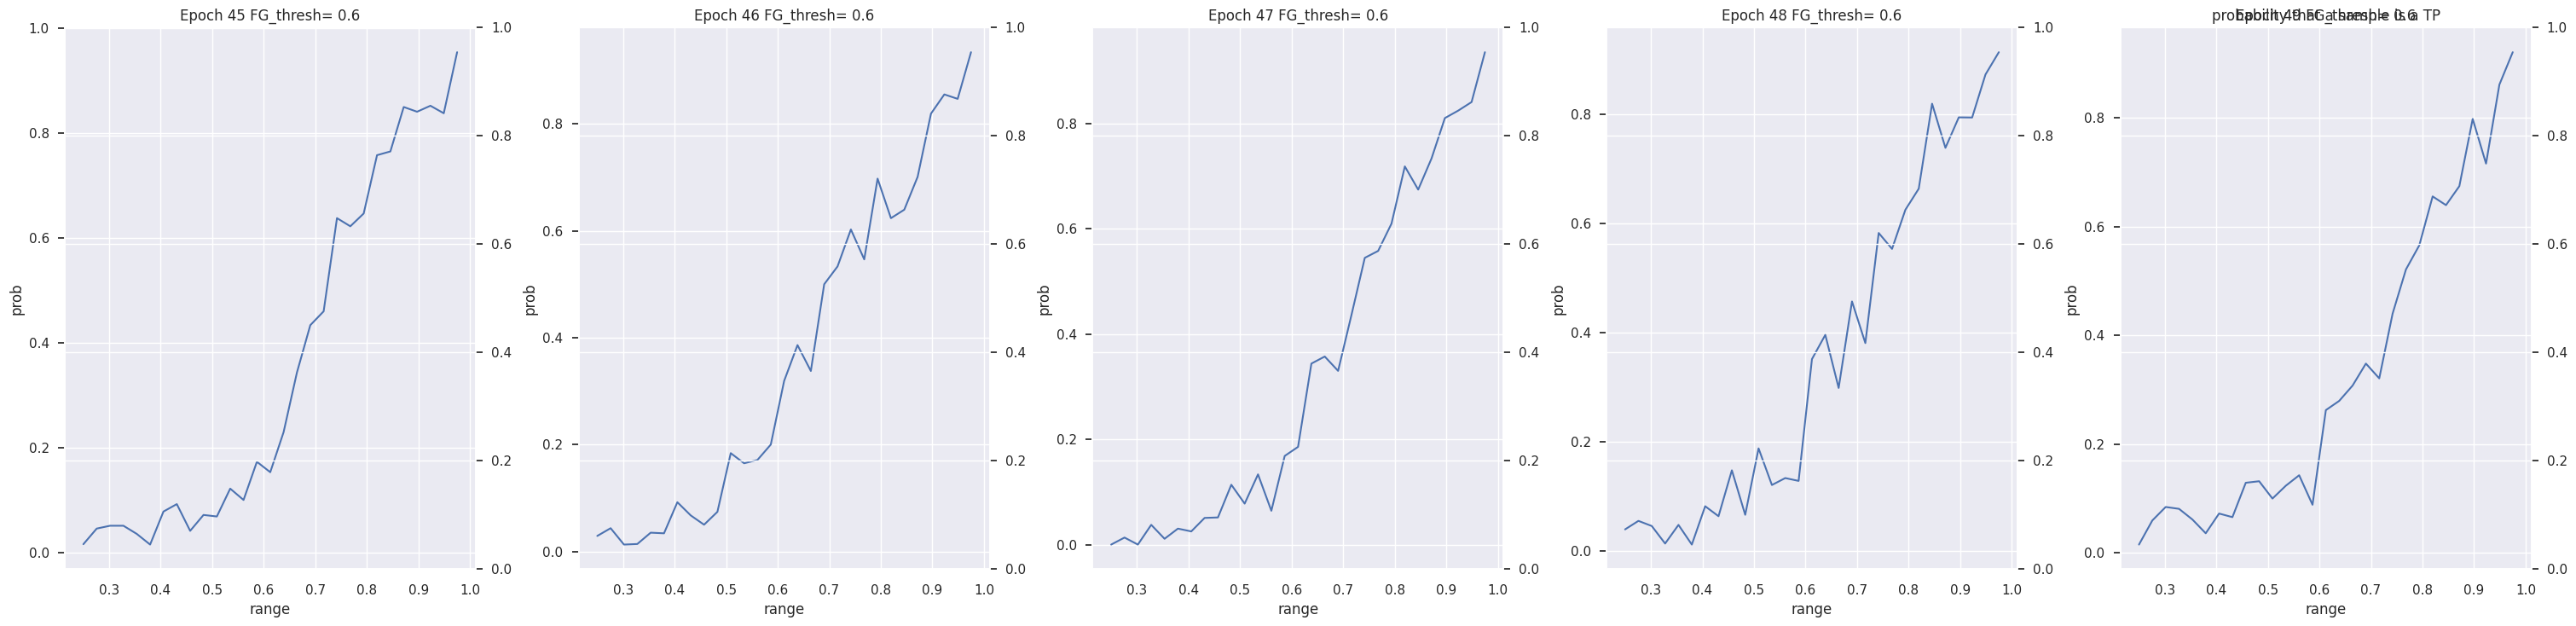

In [20]:
from matplotlib.backends.backend_pdf import PdfPages

def plot_epoch_prob(grouped_df,start,end):
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='darkgrid')
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    for iter in range(start,end):
        df = grouped_df.get_group(iter)
        values = {
        'range': [],
        'prob': [],
    }
        x = np.linspace(0.25,0.975,29)
        interval = (x[1]-x[0])
        for i,val in enumerate(x):
            iter_df = df[(df['pred_scores'] >= val) & (df['pred_scores'] < (val+interval)) & (df['class_labels']==1)]
            values['prob'].append(iter_df[iter_df['fg_wrt_gt']==True].shape[0]/iter_df.shape[0])
            values['range'].append(val)
        filter_df = pd.DataFrame(values)
        sns.lineplot(ax=axes[iter-start],data=filter_df,x='range',y='prob',markers=True,palette=palette,alpha=1.0)
        axes[iter-start].set_title(f'Epoch {iter} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[iter-start].twinx()
        ax2.set_ylim(0, 1)
    plt.title("probability that a sample is a TP")
    plt.show()
plot_epoch_prob(grouped_ot_pred_car_df,45,50)

In [21]:
prob_df = pd.DataFrame(values)
prob_df

,range,prob,tp
0,0.250000,0.012821,1
1,0.275893,0.010753,1
2,0.301786,0.011905,1
3,0.327679,0.000000,0
4,0.353571,0.013158,1
5,0.379464,0.038961,3
6,0.405357,0.000000,0
7,0.431250,0.055556,4
8,0.457143,0.000000,0
9,0.483036,0.051724,3


In [22]:
interval

0.025892857142857162

In [23]:
iou3d_ot_pred_car_df

,iou_roi_gt,iou_roi_pl,iteration,class_labels,pred_scores,threshold,roi_scores,epoch,correct,fg_wrt_gt,pred_bins
0,0.594777,0.697189,0.0,1,0.924146,0.6,0.036497,1.0,False,False,0.9
1,0.686190,0.640282,0.0,1,0.880578,0.6,0.043485,1.0,True,True,0.9
2,0.000000,0.721479,0.0,1,0.771008,0.6,0.829503,1.0,False,False,0.8
4,0.000000,0.570624,0.0,1,0.601770,0.6,0.057287,1.0,False,False,0.6
5,0.000000,0.707966,0.0,1,0.948557,0.6,0.029311,1.0,False,False,0.9
...,...,...,...,...,...,...,...,...,...,...,...
707569,0.000000,0.000000,1438.0,1,0.754854,0.6,0.143605,60.0,False,False,NaN
707570,0.000000,0.000000,1438.0,1,0.306326,0.6,0.032402,60.0,False,False,NaN
707571,0.000000,0.000000,1438.0,1,0.564434,0.6,0.030909,60.0,False,False,NaN
707638,0.000000,0.000000,1439.0,1,0.579544,0.6,0.080209,60.0,False,False,NaN


In [24]:
from matplotlib.backends.backend_pdf import PdfPages
start = 1
end = 6
p =sns.cubehelix_palette(start=.5, rot=-.5)
palette = [p[1],p[4]]
sns.set_theme(style='dark')
for i in range(0,3):
 with PdfPages('plots.pdf') as pdf:
    for i in range(start,end):
        f, axes = plt.subplots(1,2, figsize=(15,5))
        sns.histplot(ax=axes[0],data=grouped_ot_iou_df.get_group(float(i)),x='iou_roi_pl',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,legend=True,palette=palette,alpha=1.0)
        sns.histplot(ax=axes[1],data=grouped_ot_pred_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,palette=palette,alpha=1.0)

        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        plt.title(f'Epoch {i} FG_thresh= {threshold}')
        # Iterate over the subplots in axes
        ax2_1 = axes[0].twinx()
        ax2_2 = axes[1].twinx()

        # Set the y-axis limits to 0 and 1 for each twin axes
        ax2_1.set_ylim(0, 1)
        ax2_2.set_ylim(0, 1)

        # Remove the spines and ticks of the left y-axis for each subplot
        ax2_1.spines['left'].set_visible(False)
        ax2_1.yaxis.set_ticks_position('none')
        ax2_2.spines['left'].set_visible(False)
        ax2_2.yaxis.set_ticks_position('none')

        # Remove the spines and ticks of the right y-axis for each subplot
        ax2_1.spines['right'].set_linewidth(0.5)
        ax2_1.spines['right'].set_color('black')
        ax2_1.spines['right'].set_visible(True)
        ax2_1.yaxis.tick_right()
        ax2_1.yaxis.set_label_position('right')

        ax2_2.spines['right'].set_linewidth(0.5)
        ax2_2.spines['right'].set_color('black')
        ax2_2.spines['right'].set_visible(True)
        ax2_2.yaxis.tick_right()
        ax2_2.yaxis.set_label_position('right')
        pdf.savefig(f)
        plt.close(f)
    # Set the label for the right y-axis
f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
plt.show()


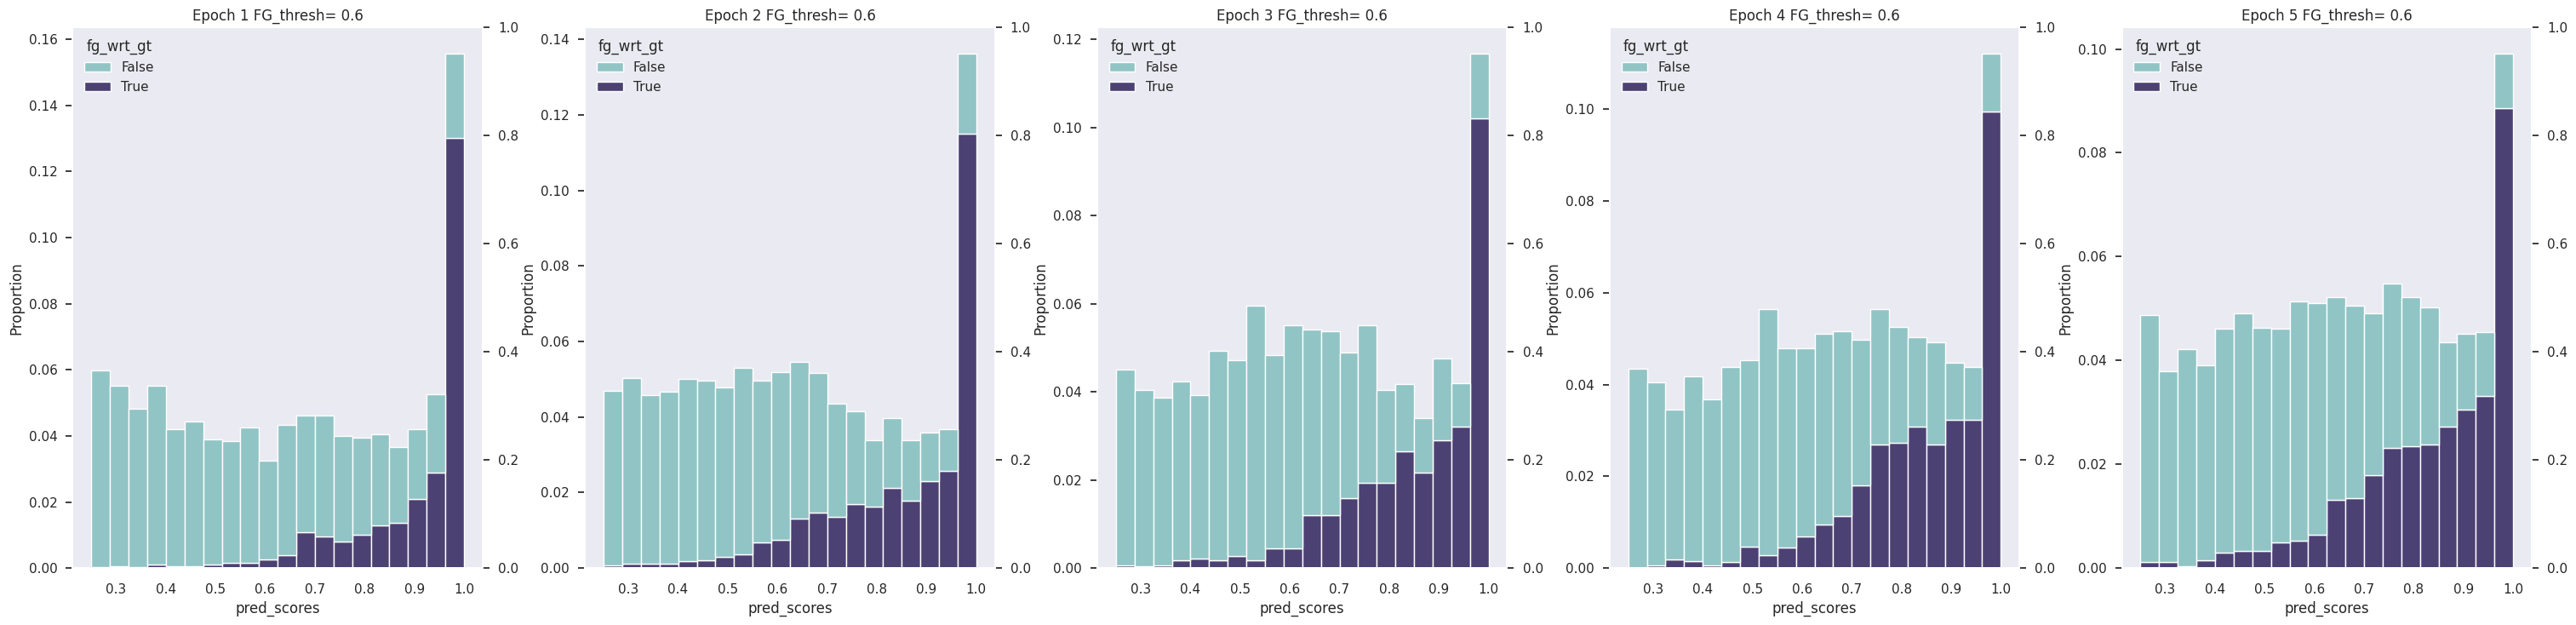

In [48]:
from matplotlib.backends.backend_pdf import PdfPages

def plot_epoch(grouped_df,start,end):
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='dark')
    grouped_ot_pred_df = iou3d_ot_pred_df.groupby('epoch')
    # for i in range(0,3):
    # with PdfPages('plots.pdf') as pdf:
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    for i in range(start,end):
        sns.histplot(ax=axes[i-start],data=grouped_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,palette=palette,alpha=1.0)
        axes[i-start].set_title(f'Epoch {i} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[i-start].twinx()
        ax2.set_ylim(0, 1)
    plt.show()
plot_epoch(grouped_ot_pred_df,1,6)


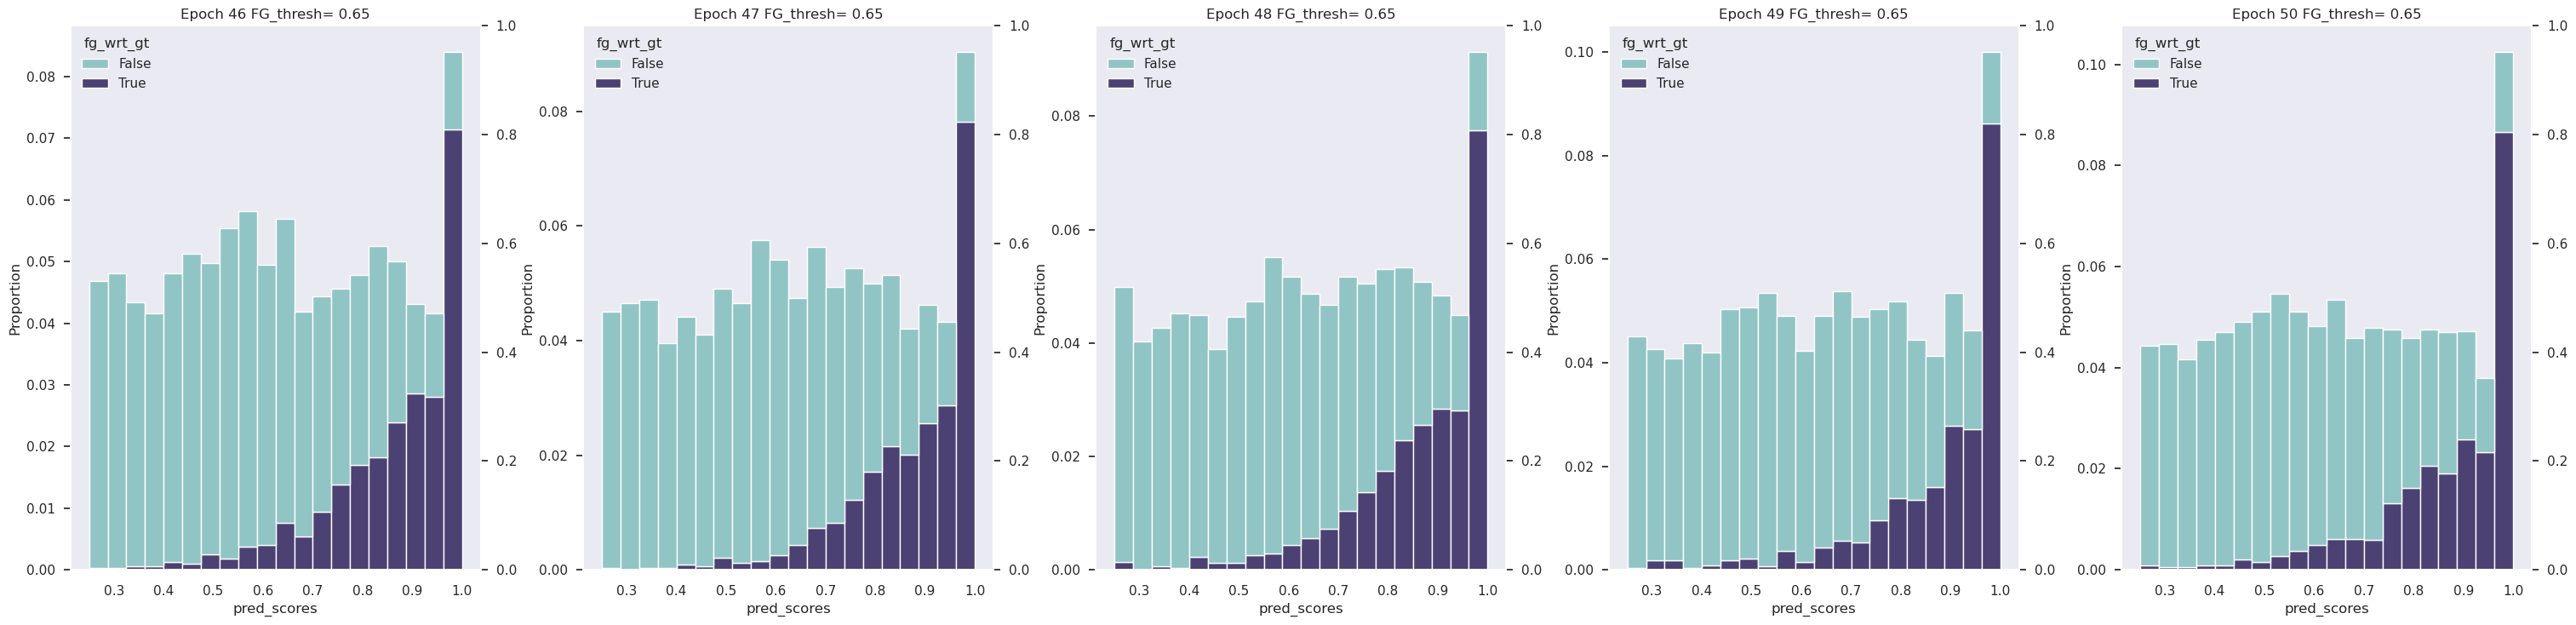

In [22]:
plot_epoch(grouped_ot_pred_df,46,51)

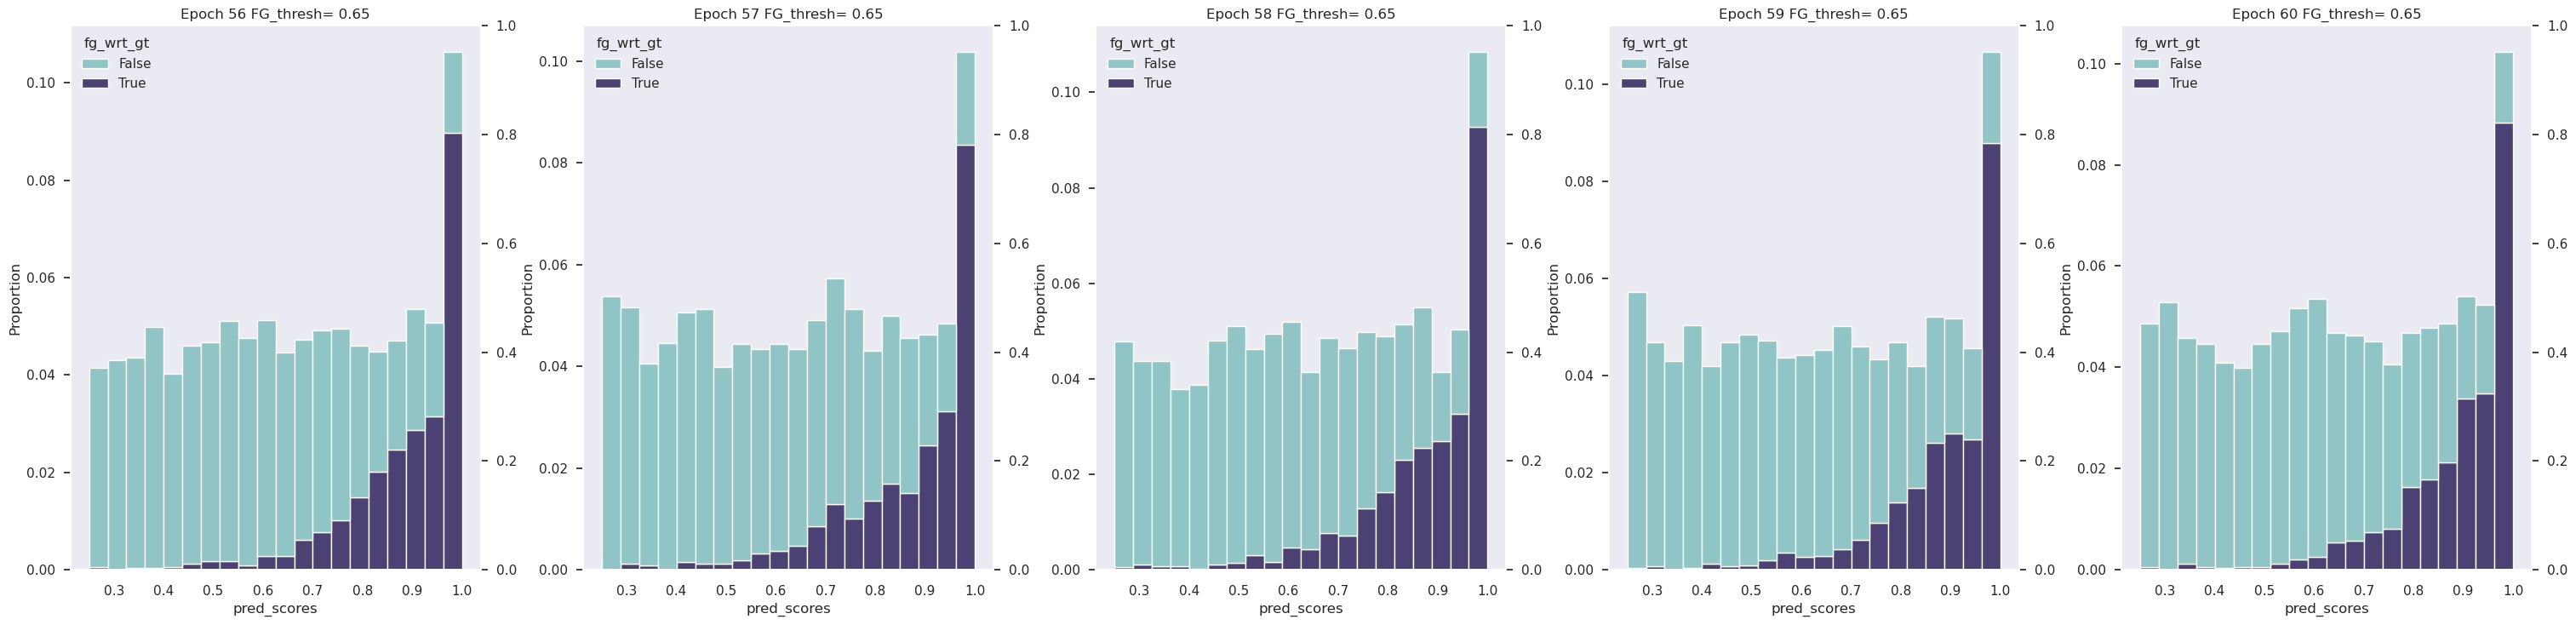

In [23]:
plot_epoch(grouped_ot_pred_df,56,61)

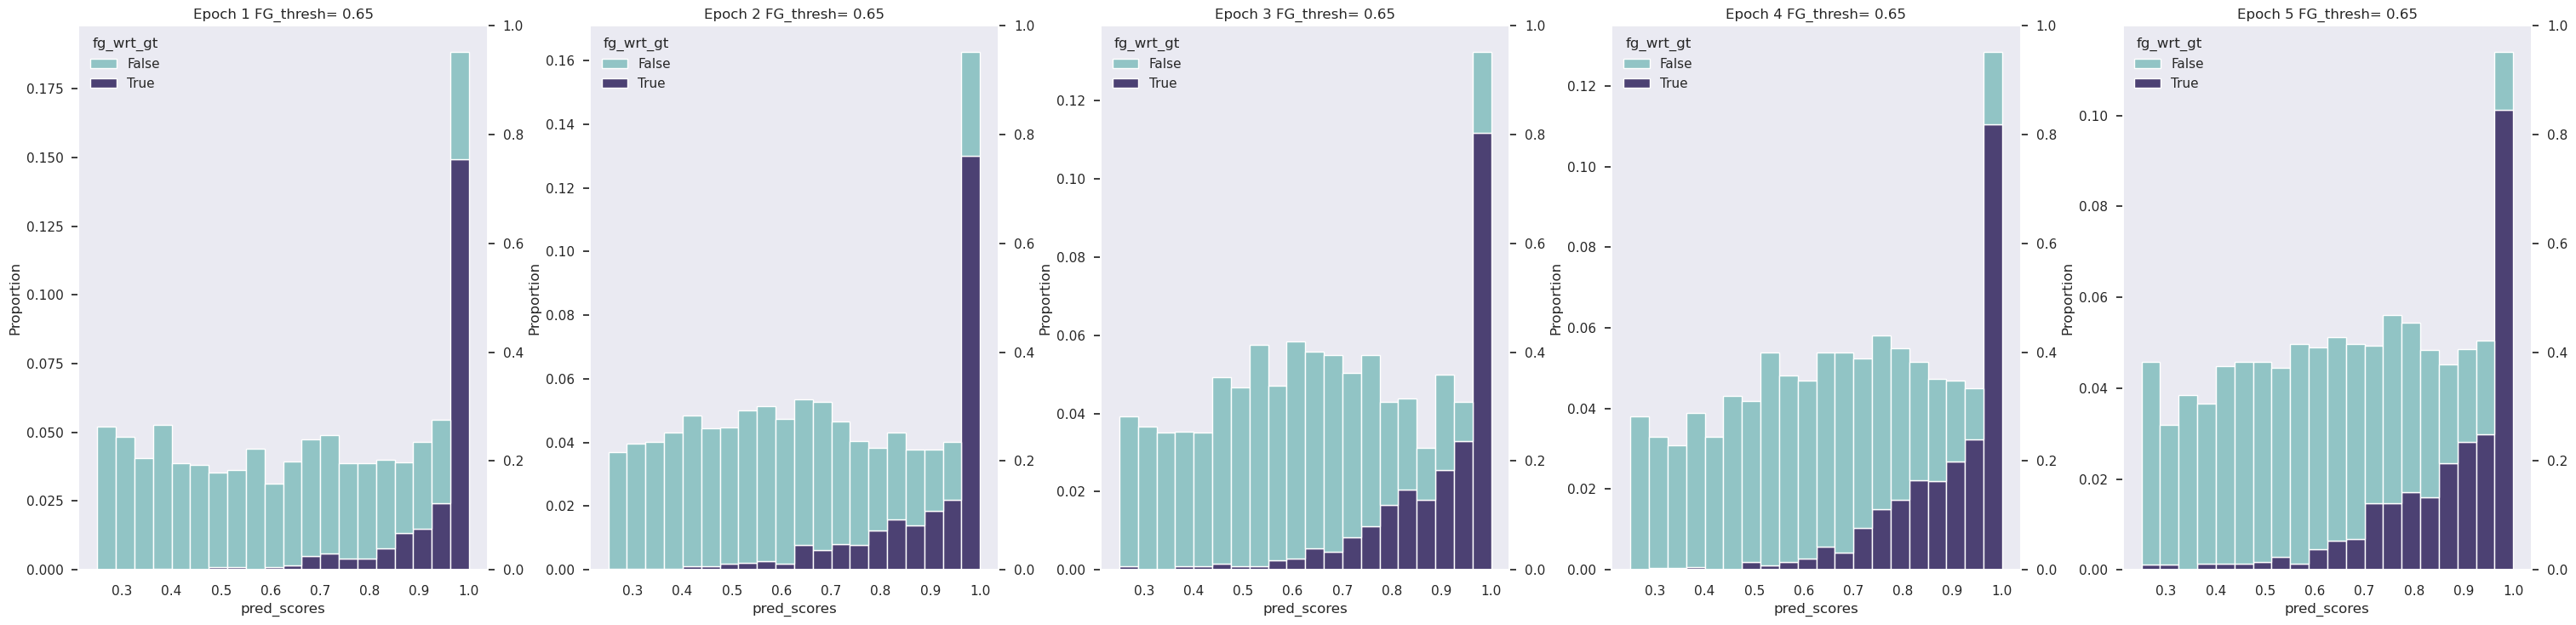

In [305]:
plot_epoch(grouped_ot_pred_car_df,1,6)

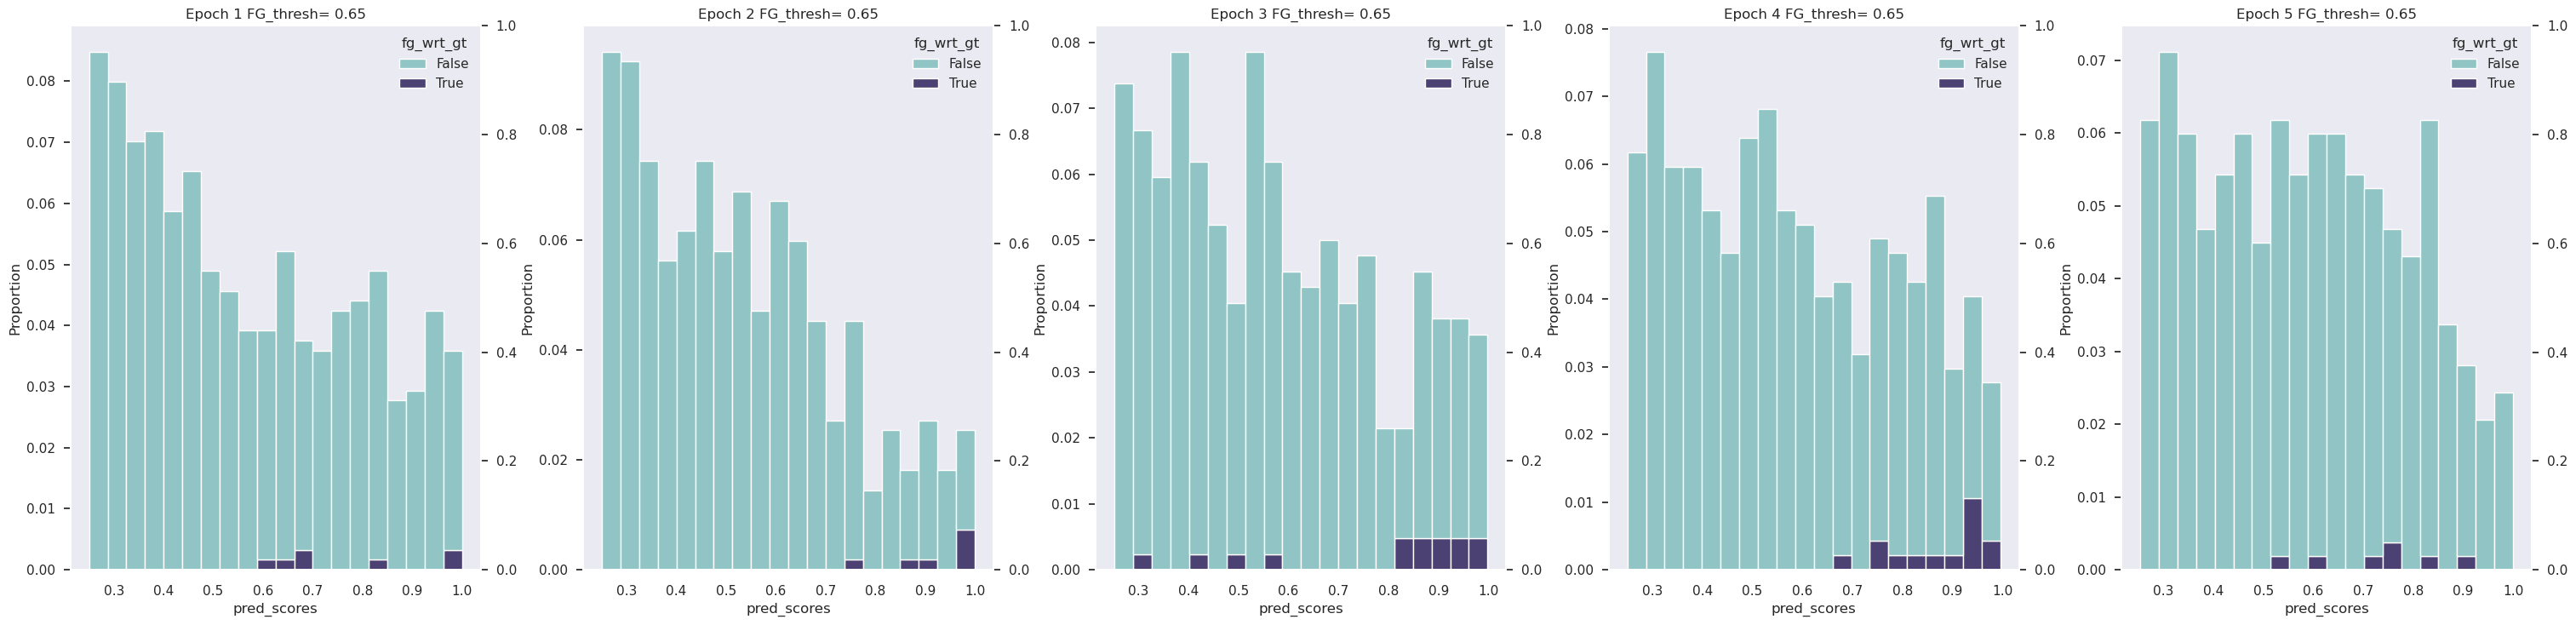

In [306]:
plot_epoch(grouped_ot_pred_ped_df,1,6)

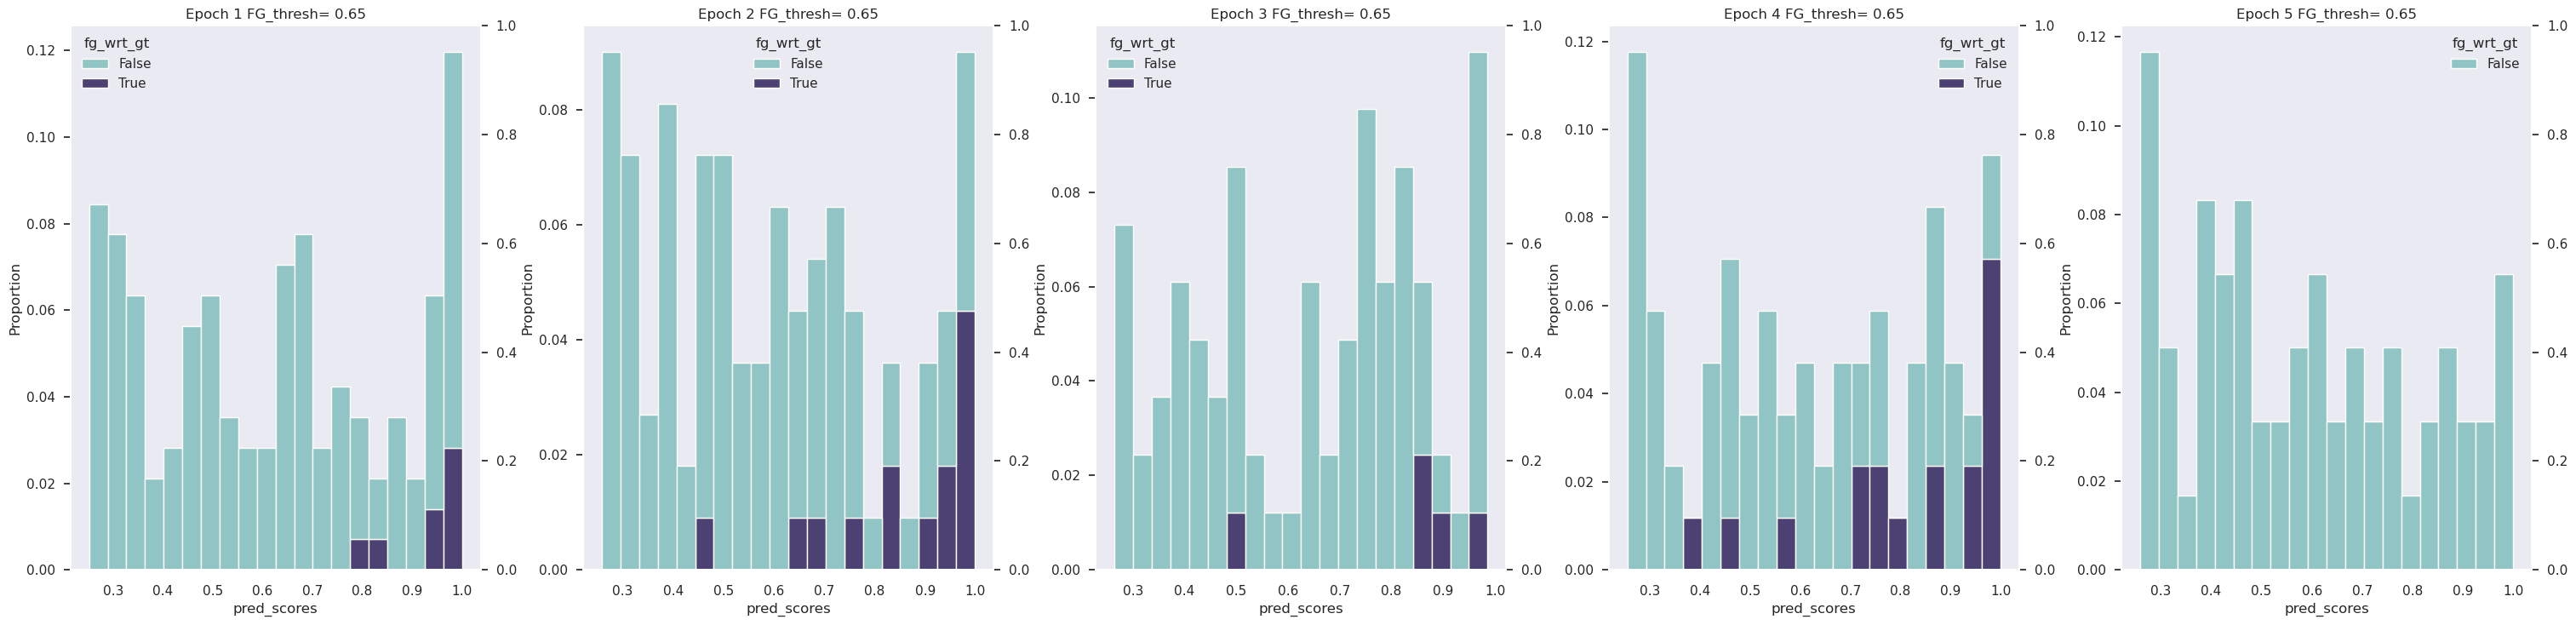

In [307]:
plot_epoch(grouped_ot_pred_cyc_df,1,6)

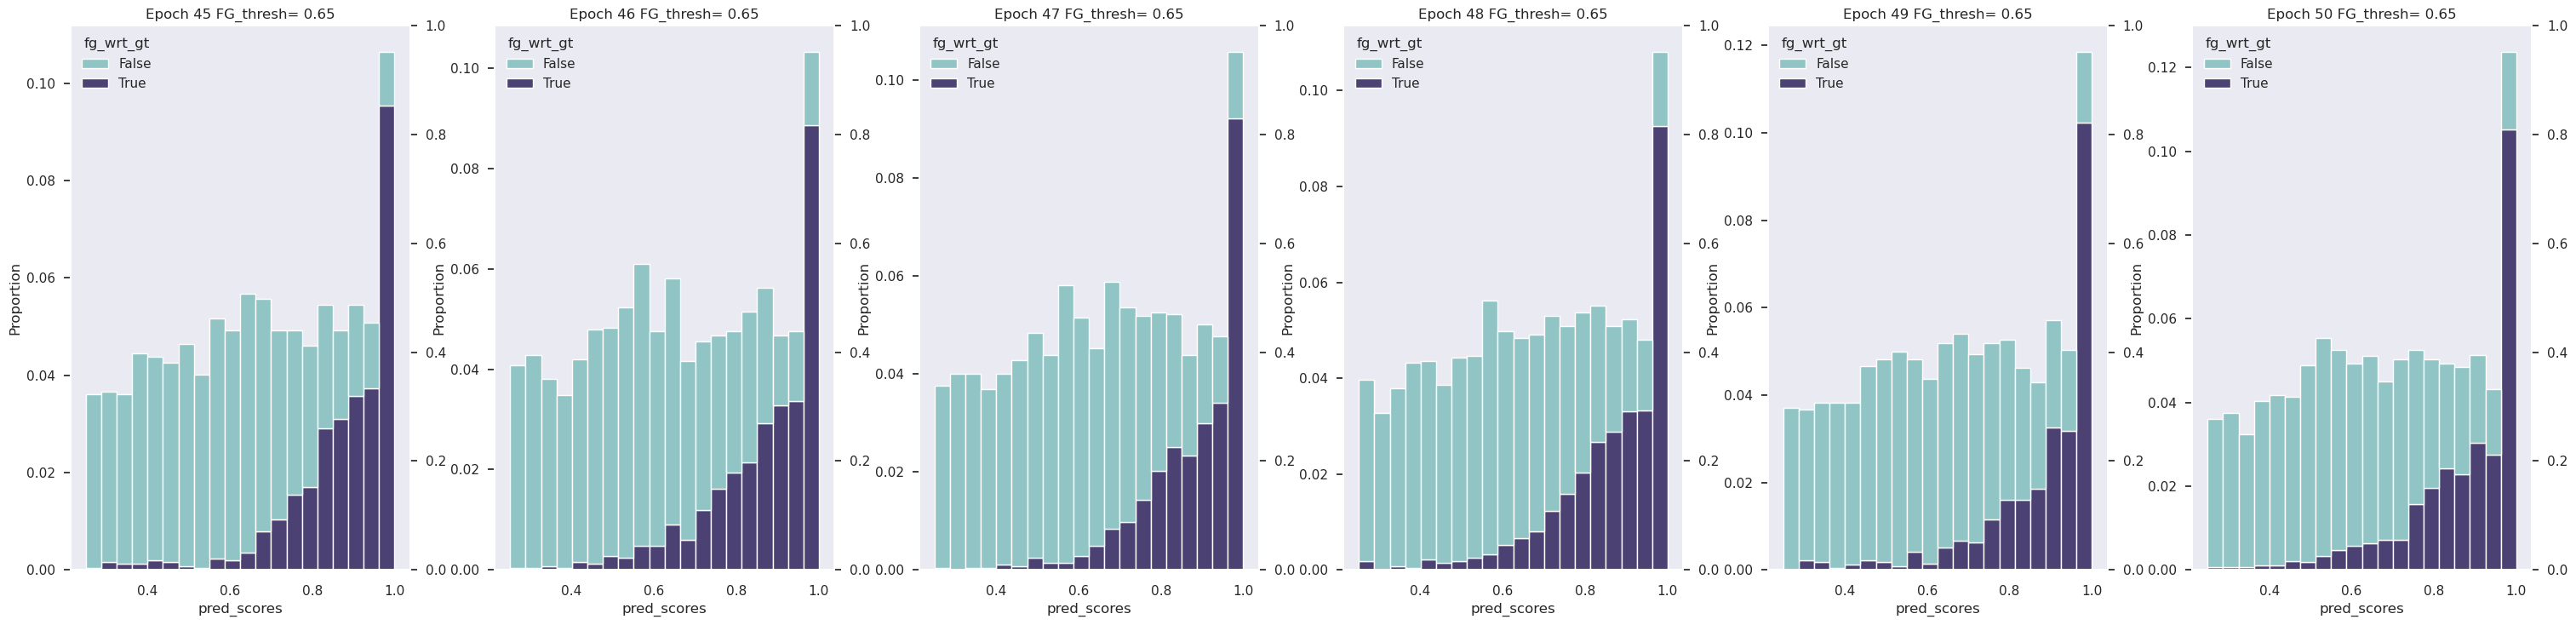

In [308]:
plot_epoch(grouped_ot_pred_car_df,45,51)

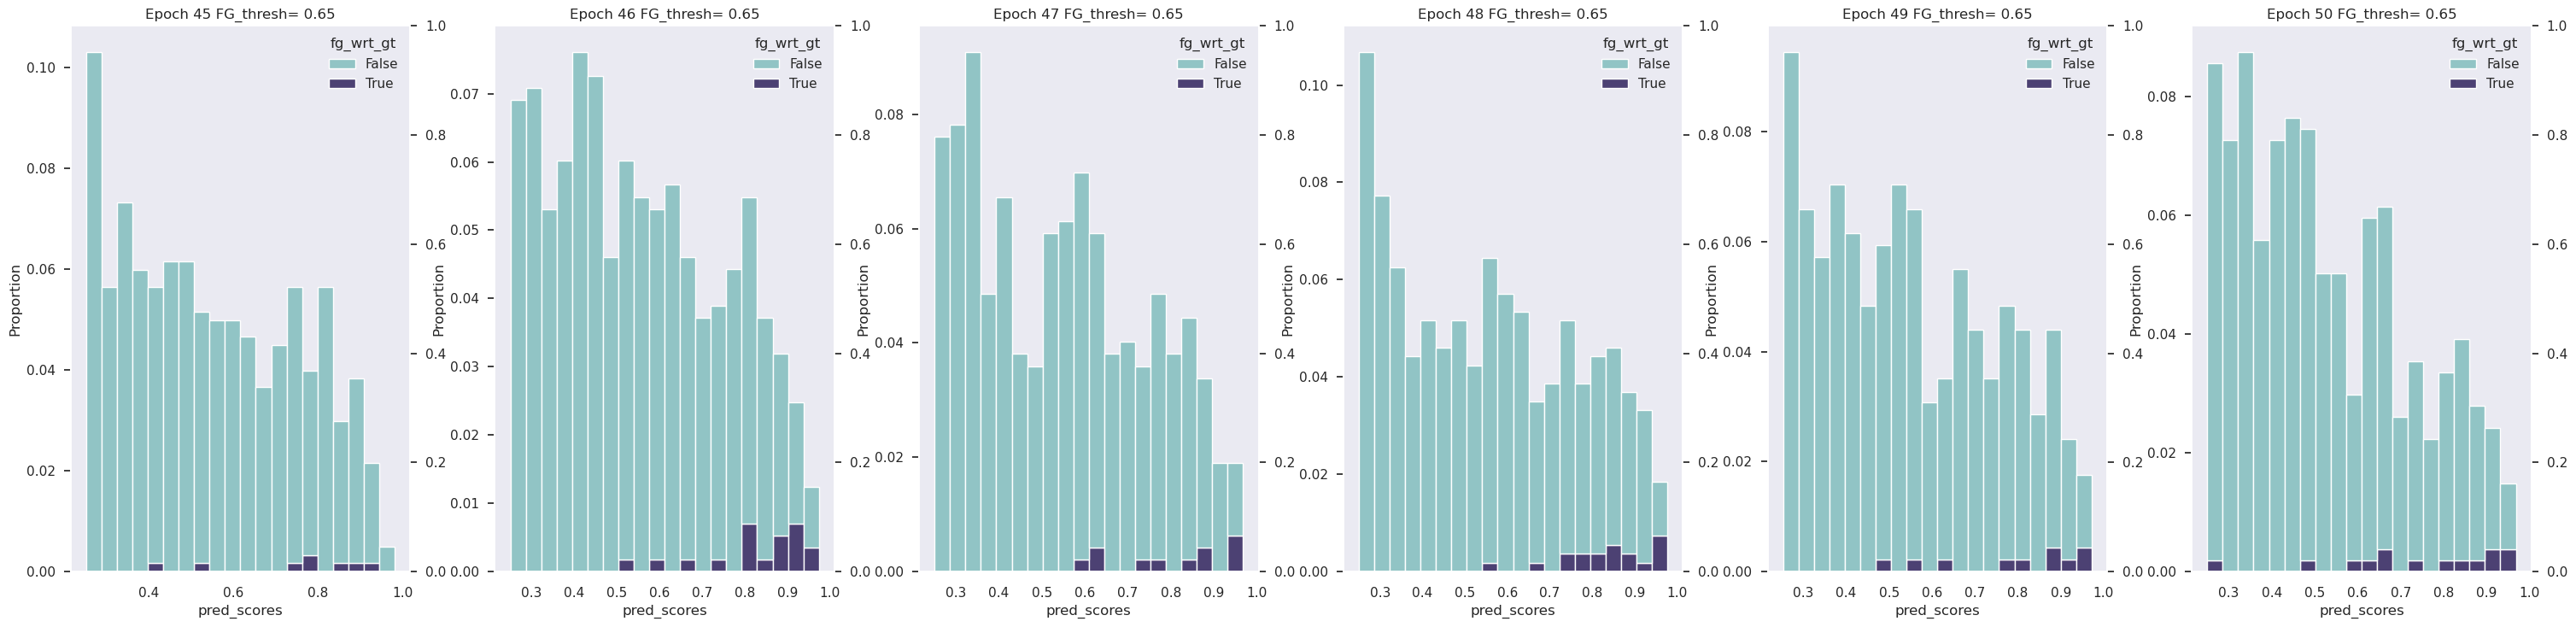

In [309]:
plot_epoch(grouped_ot_pred_ped_df,45,51)

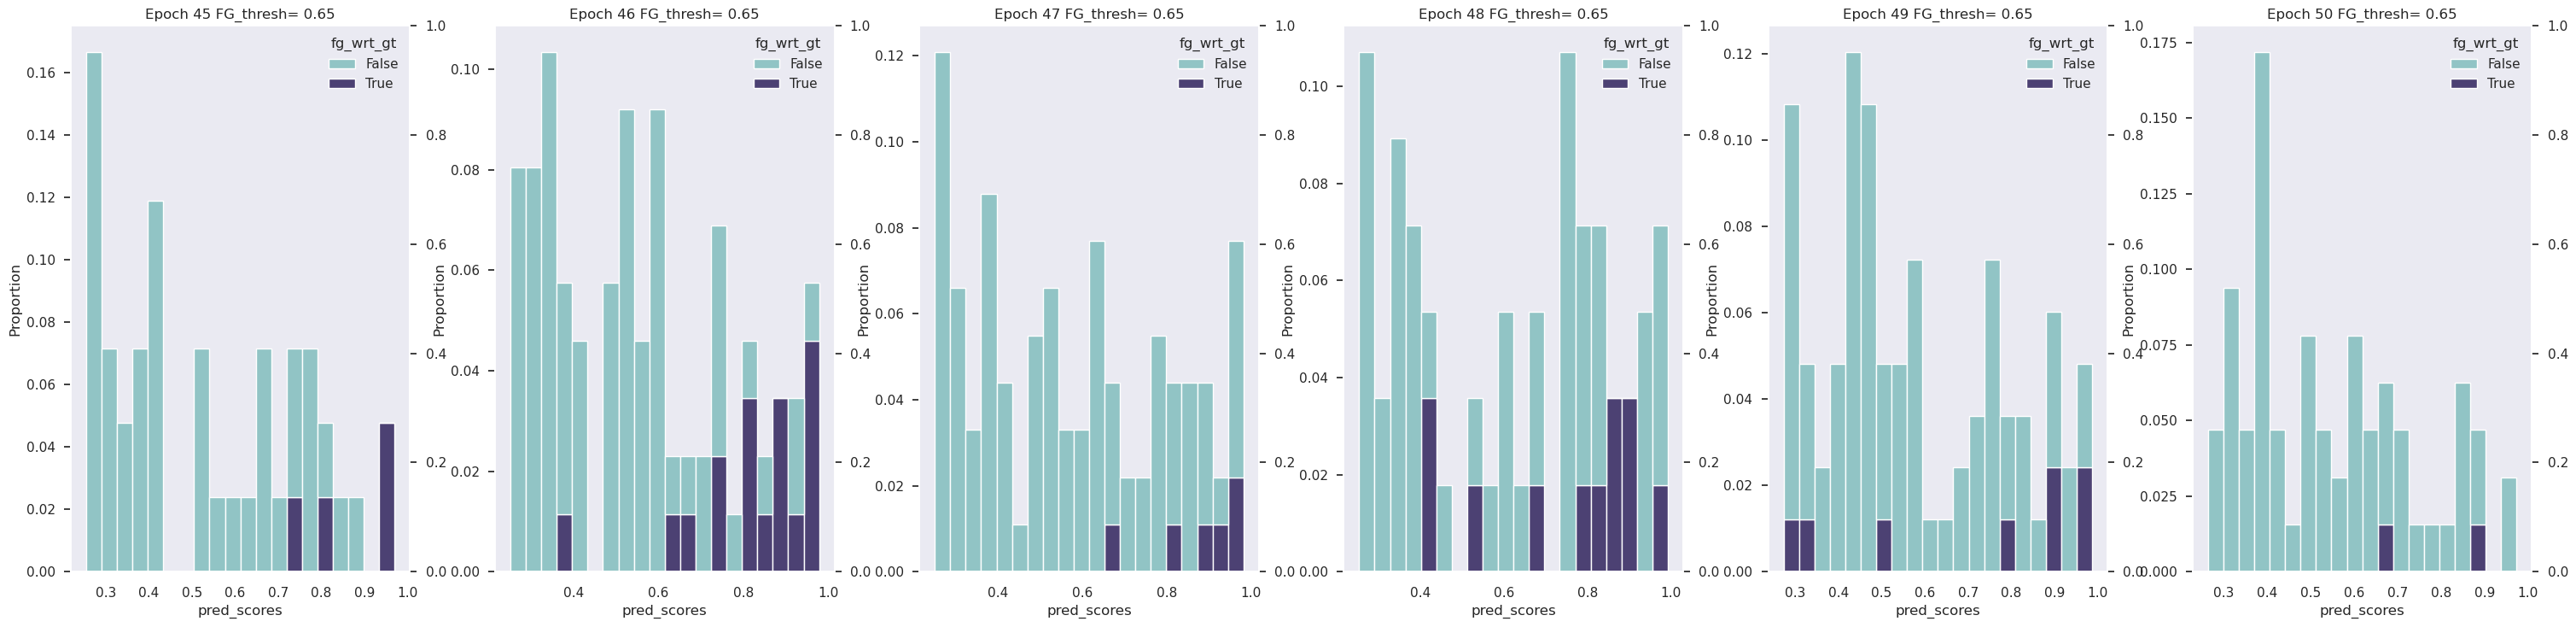

In [310]:
plot_epoch(grouped_ot_pred_cyc_df,45,51)

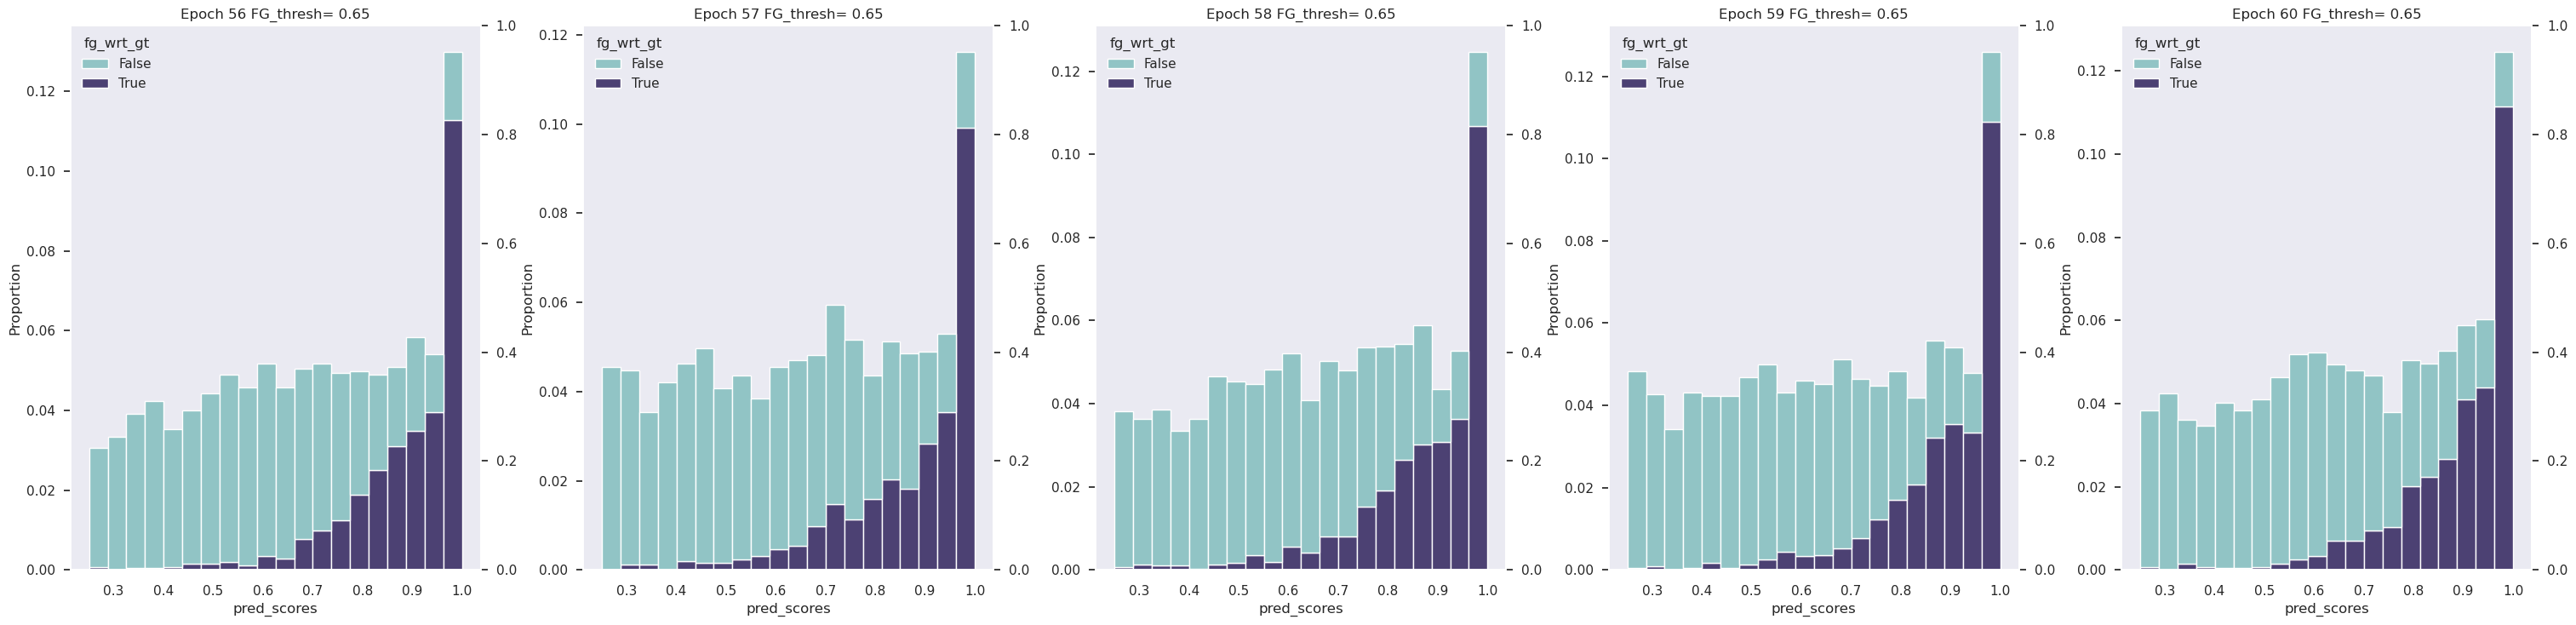

In [314]:
plot_epoch(grouped_ot_pred_car_df,56,61)

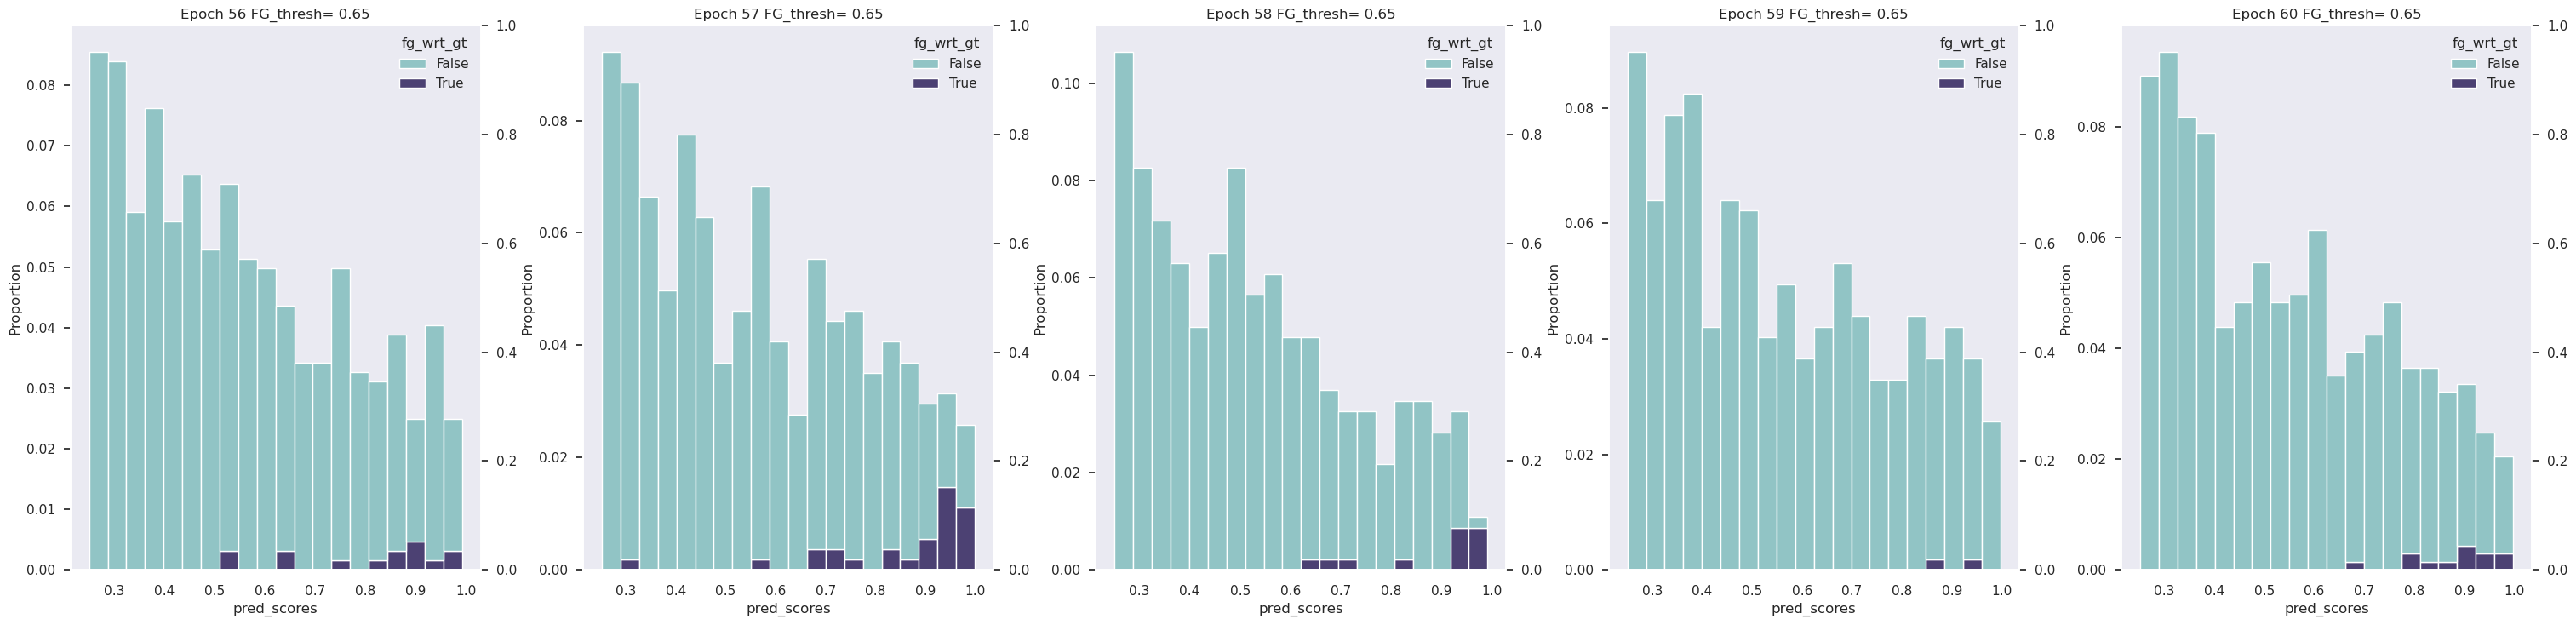

In [315]:
plot_epoch(grouped_ot_pred_ped_df,56,61)

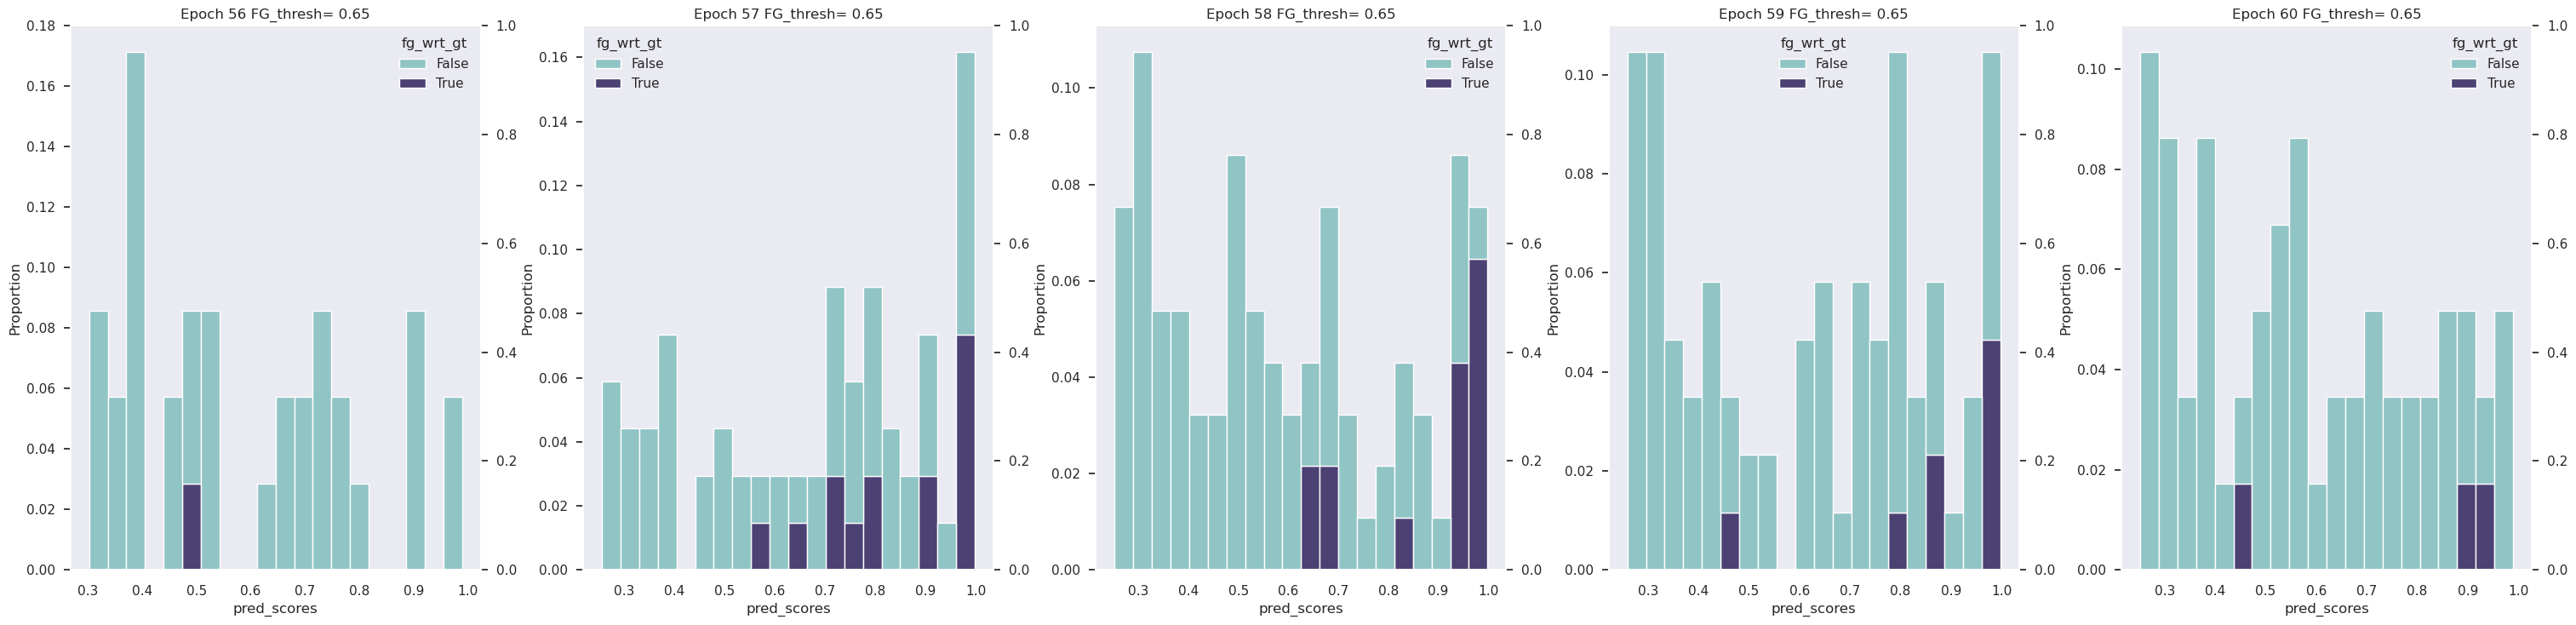

In [316]:
plot_epoch(grouped_ot_pred_cyc_df,56,61)

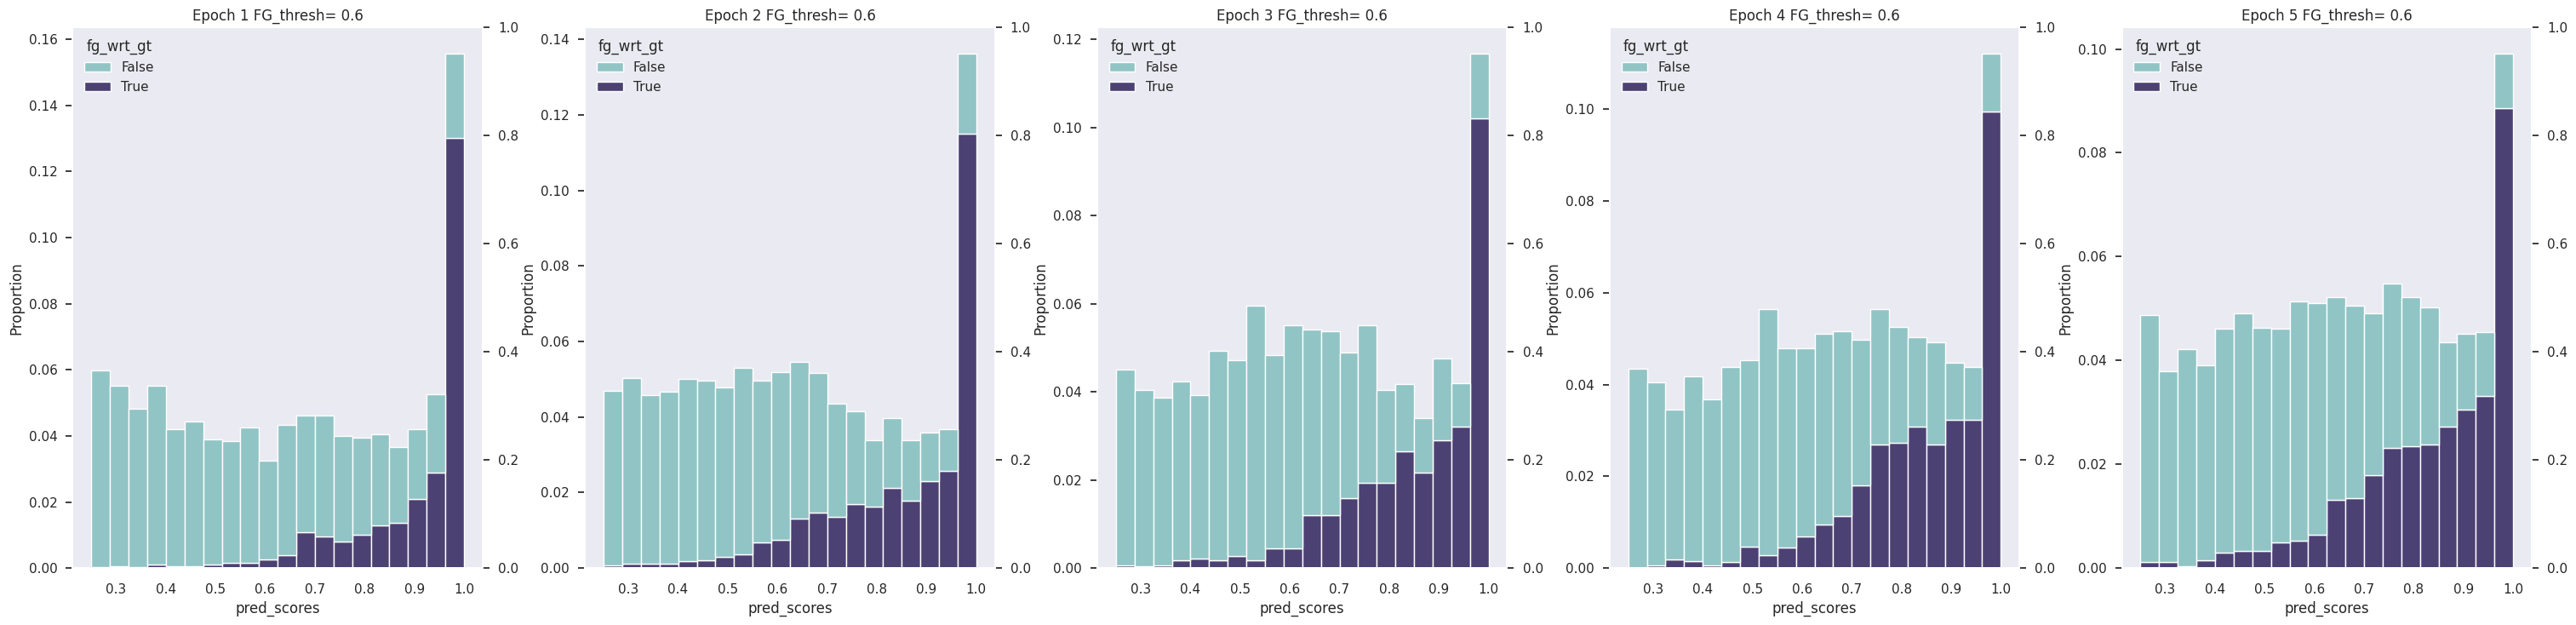

In [27]:

def plot_epoch(grouped_df,start,end):
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='dark')
    # for i in range(0,3):
    # with PdfPages('plots.pdf') as pdf:
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    for i in range(start,end):
        sns.histplot(ax=axes[i-start],data=grouped_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,palette=palette,alpha=1.0)
        axes[i-start].set_title(f'Epoch {i} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[i-start].twinx()
        ax2.set_ylim(0, 1)
    plt.show()
plot_epoch(grouped_ot_pred_df,1,6)

In [34]:
import numpy as np

def gaussian(row):
    x = row['pred_scores']
    # mu = row['mean']
    # sigma =8*row['variance']
    mu = 0.5
    sigma = 0.11
    exponent =  -1*(x - mu)**2 / 2*sigma**2
    scaler = 1/(1-mu)
    return scaler * np.exp(exponent)

def thresholding(row):
    row['gaussian'] = 1 if row['pred_scores'] >= row['threshold'] else row['gaussian']
    return row['gaussian']

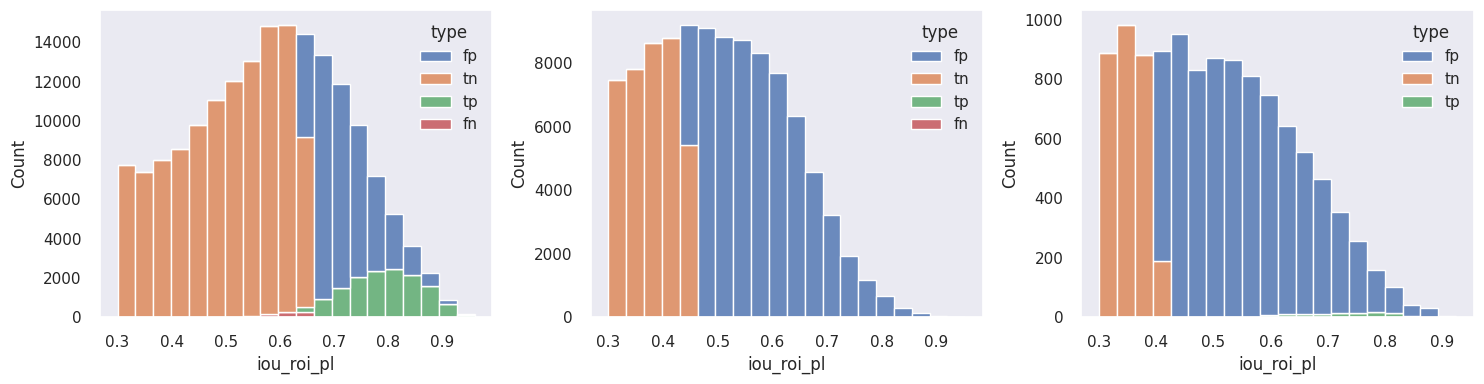

In [54]:
stats = iou3d_old_thresh
fg_gt_thresh = 0.75
fg_pl_thresh = [0.65, 0.45, 0.4]

stats_dict = {
 'iou_roi_gt': stats['iou_roi_gt'],
 'iou_roi_pl': stats['iou_roi_pl'],
 'iteration' : stats['iteration'],
 'class_labels': stats['class_labels'],
 'pred_scores': stats['pred_scores']
}
stats_df = pd.DataFrame(stats_dict)
stats_df['type'] = 'none'
stats_df['epoch'] = (stats_df['iteration']) // 24 + 1
stats_df = stats_df[0.3 <= stats_df['iou_roi_pl']]
p = sns.color_palette('rocket')
palette = [p[0],p[2]]
f, axes = plt.subplots(1,3, figsize=(15,4))
for i in range(0,3):
 cls_df = stats_df[stats_df['class_labels'] == i + 1]
 tp_mask = (fg_gt_thresh <= cls_df['iou_roi_gt']) & (fg_pl_thresh[i] <= cls_df['iou_roi_pl'])
 fp_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh) & (fg_pl_thresh[i] <= cls_df['iou_roi_pl'])
 fn_mask = (fg_gt_thresh <= cls_df['iou_roi_gt']) & (cls_df['iou_roi_pl'] < fg_pl_thresh[i])
 tn_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh) & (cls_df['iou_roi_pl'] < fg_pl_thresh[i])
 cls_df['type'][tp_mask] = 'tp'
 cls_df['type'][fp_mask] = 'fp'
 cls_df['type'][fn_mask] = 'fn'
 cls_df['type'][tn_mask] = 'tn'

 sns.histplot(ax=axes[i],data=cls_df, x="iou_roi_pl",hue='type',fill=True, kde=False,stat='count',multiple="stack",legend=True, bins=20, alpha=0.8)
 f.tight_layout()
 f.subplots_adjust(wspace=0.25, hspace=0.2)
 # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
plt.show()

In [77]:
p = sns.color_palette("muted")
p

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

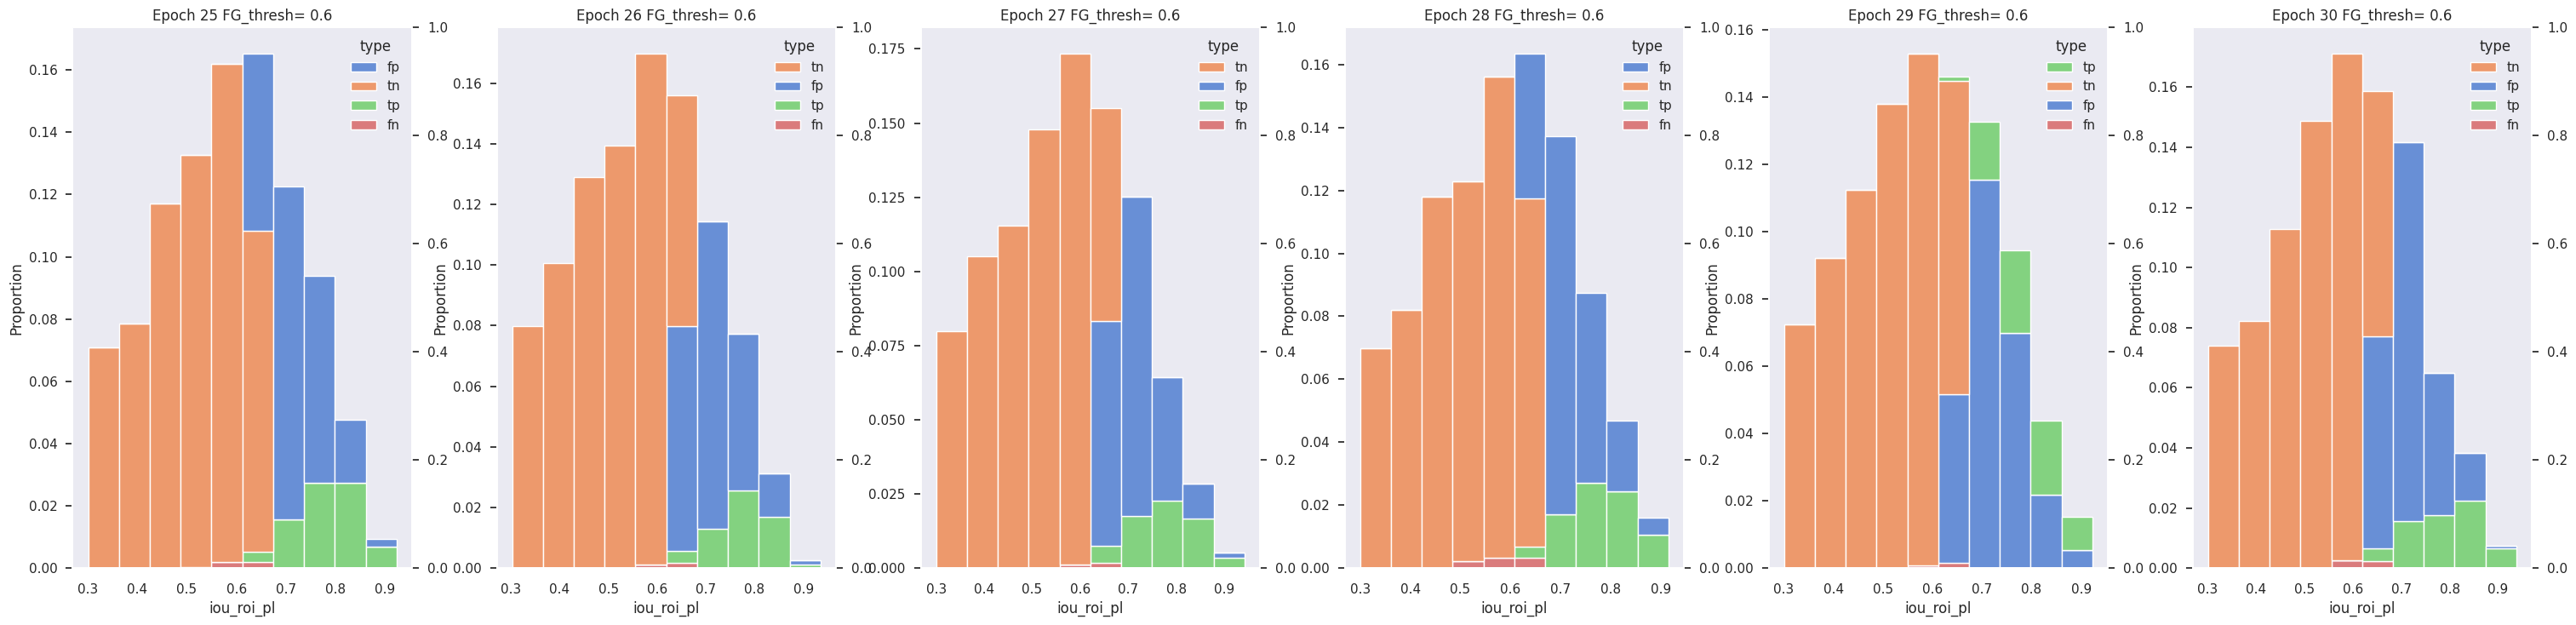

In [95]:
from matplotlib.backends.backend_pdf import PdfPages

def plot_epoch(df,cls,start,end):

    cls_map = {'Car':1,'Ped':2,'Cyc':3}
    fg_gt_thresh = 0.75
    fg_pl_thresh = [0.65, 0.45, 0.4]
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    # group by each epoch
    grouped_df = df.groupby('epoch')
    cls_id = cls_map[cls]
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    palette = {'tp':p[2],'fp':p[0],'fn':p[3],'tn':p[1]}
    for i in range(start,end):
        # get particular epoch
        filter_df = grouped_df.get_group(float(i)) 
        cls_df = filter_df[filter_df['class_labels']==(cls_id)] # filter classes and tp fp fn tn classwise
        tp_mask = (fg_gt_thresh <= cls_df['iou_roi_gt']) & (fg_pl_thresh[cls_id-1] <= cls_df['iou_roi_pl']) 
        fp_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh) & (fg_pl_thresh[cls_id-1] <= cls_df['iou_roi_pl'])
        fn_mask = (fg_gt_thresh <= cls_df['iou_roi_gt']) & (cls_df['iou_roi_pl'] < fg_pl_thresh[cls_id-1])
        tn_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh) & (cls_df['iou_roi_pl'] < fg_pl_thresh[cls_id-1])
        cls_df['type'][tp_mask] = 'tp'
        cls_df['type'][fp_mask] = 'fp'
        cls_df['type'][fn_mask] = 'fn'
        cls_df['type'][tn_mask] = 'tn'
        sns.histplot(ax=axes[i-start],data=cls_df,x='iou_roi_pl',hue='type',multiple='stack',stat='proportion',bins=10,fill=True,alpha=0.8,palette=palette)
        axes[i-start].set_title(f'Epoch {i} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[i-start].twinx()
        ax2.set_ylim(0, 1)
    plt.show()
plot_epoch(stats_df,'Car',25,31)

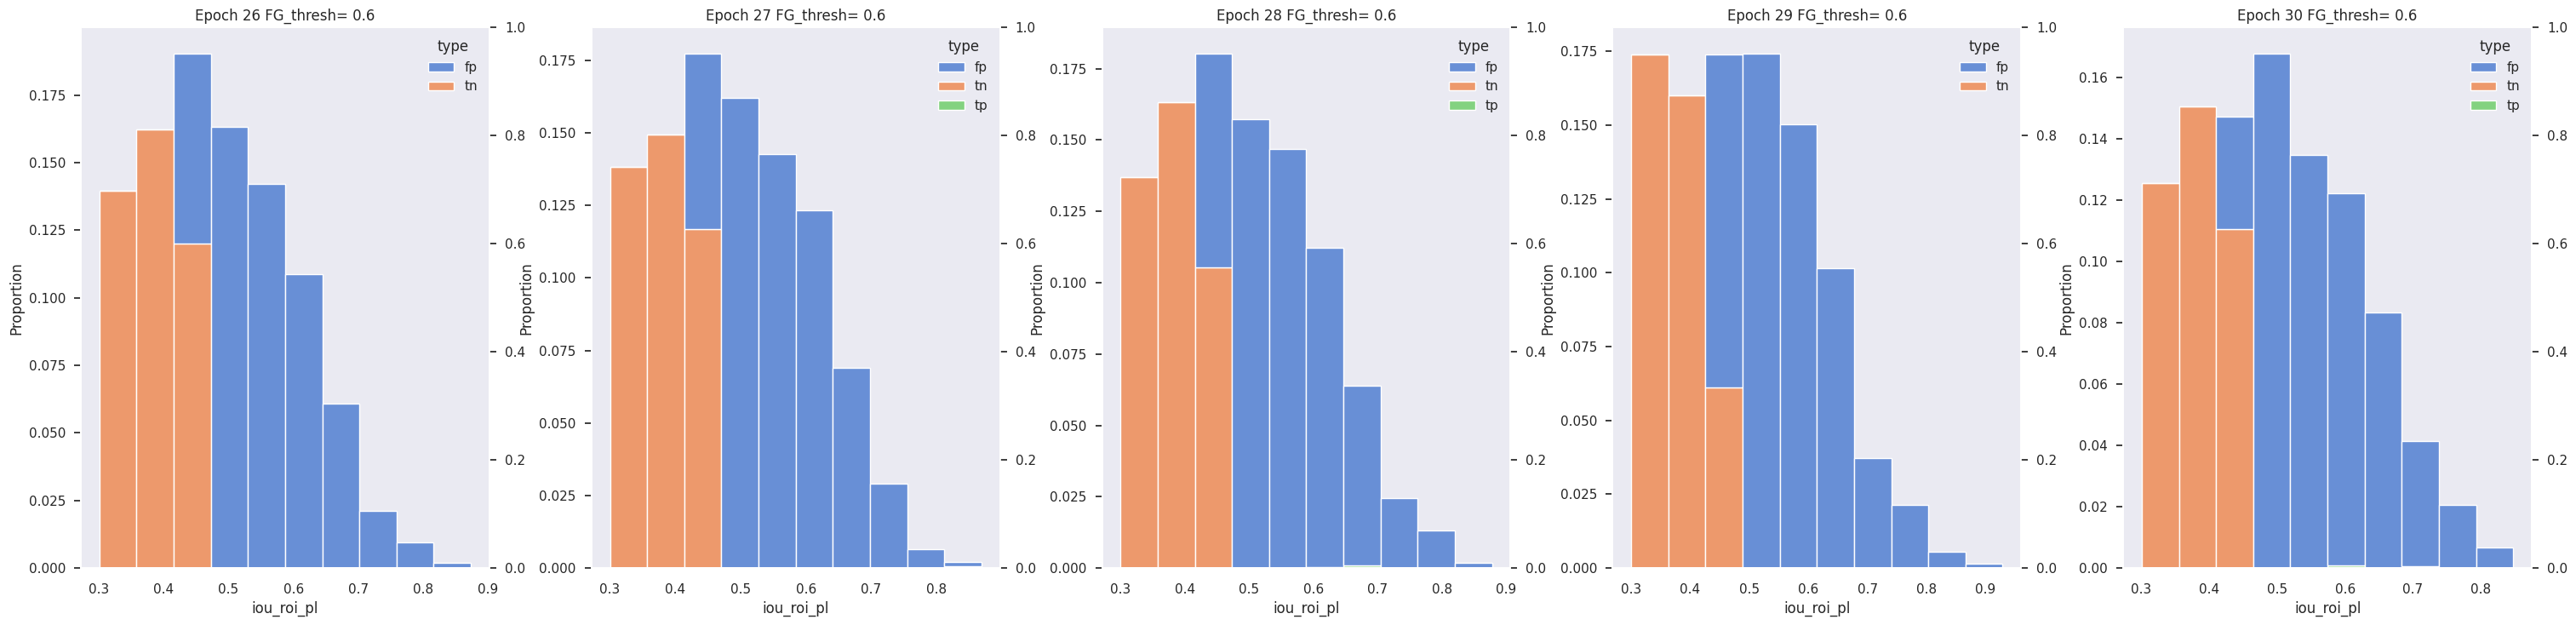

In [96]:
plot_epoch(stats_df,'Ped',26,31)

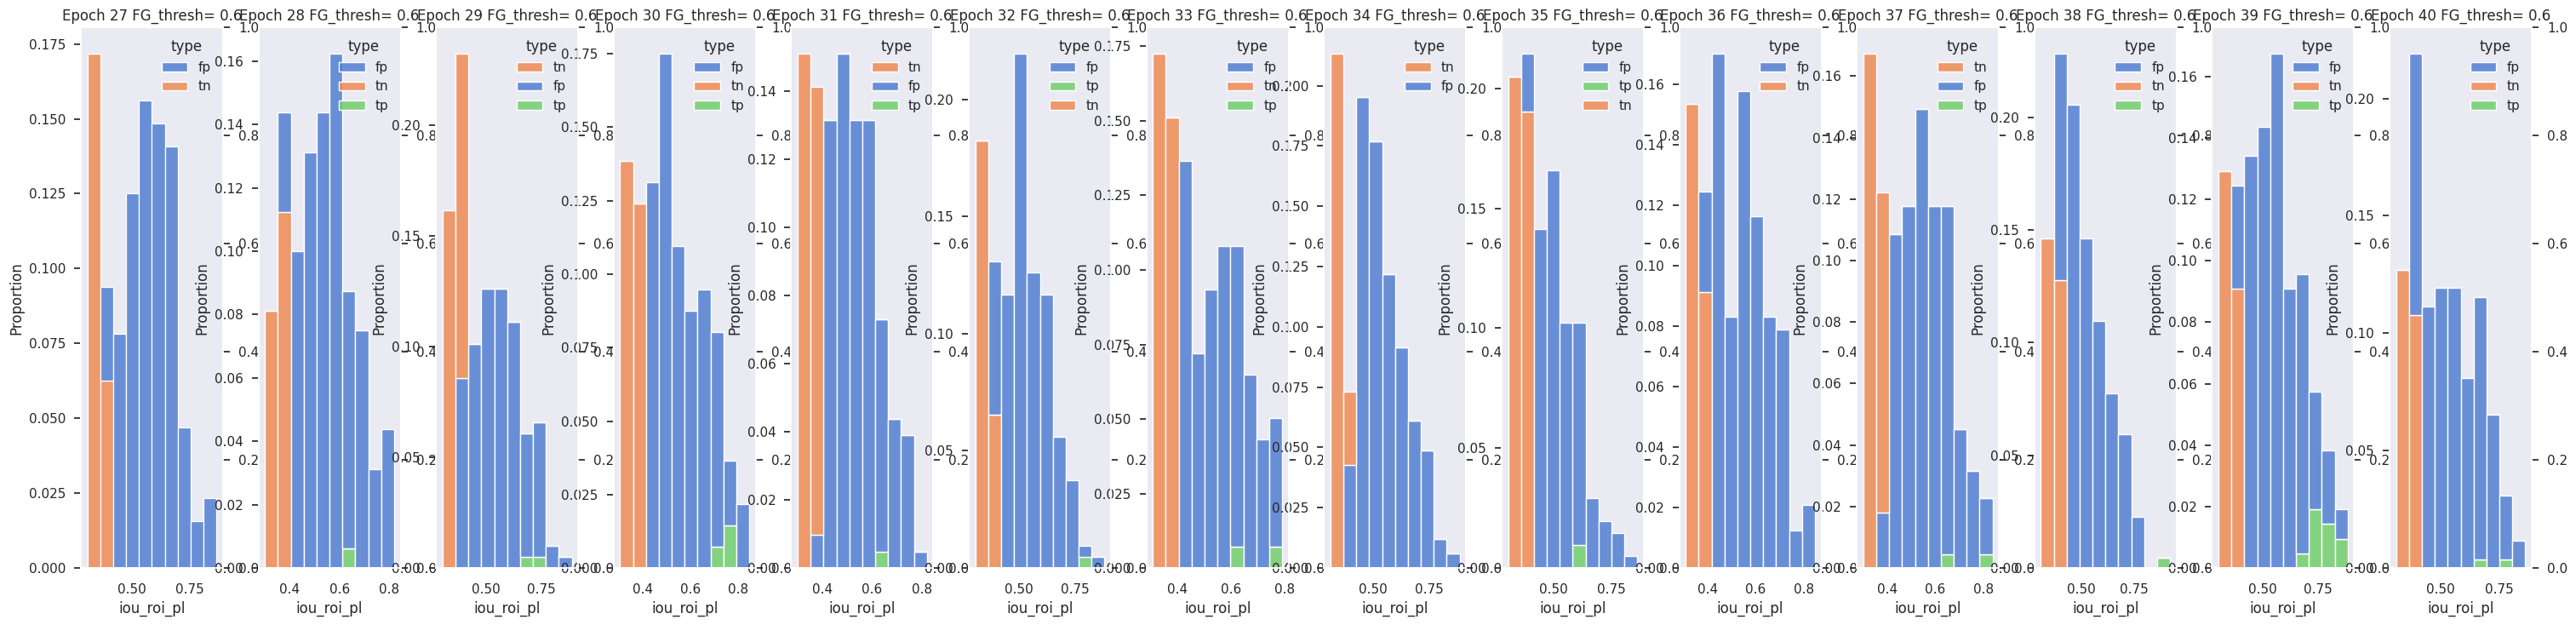

In [99]:
plot_epoch(stats_df,'Cyc',27,31)

In [36]:
iou3d_ot_iou_df['variance'] = iou3d_ot_iou_df.groupby('epoch')['pred_scores'].transform('var')
iou3d_ot_iou_df['mean'] = iou3d_ot_iou_df.groupby('epoch')['pred_scores'].transform('mean')

In [37]:
iou3d_ot_iou_df

,iou_roi_gt,iou_roi_pl,iteration,class_labels,pred_scores,threshold,roi_scores,epoch,correct,fg_wrt_gt,variance,mean,gaussian
0,0.594777,0.697189,0.0,1,0.924146,0.6,0.036497,1.0,False,False,0.115062,0.530350,1.000000
1,0.686190,0.640282,0.0,1,0.880578,0.6,0.043485,1.0,True,True,0.115062,0.530350,1.000000
2,0.000000,0.721479,0.0,1,0.771008,0.6,0.829503,1.0,False,False,0.115062,0.530350,1.000000
3,0.000000,0.742094,0.0,2,0.814994,0.6,0.491779,1.0,False,False,0.115062,0.530350,1.000000
4,0.000000,0.570624,0.0,1,0.601770,0.6,0.057287,1.0,False,False,0.115062,0.530350,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
707619,0.000000,0.259483,1439.0,3,0.001075,0.6,0.034821,60.0,False,False,0.115940,0.423004,1.996990
707621,0.000000,0.545347,1439.0,2,0.049681,0.6,0.316081,60.0,False,False,0.115940,0.423004,1.997548
707622,0.000000,0.430275,1439.0,2,0.370118,0.6,0.096573,60.0,False,False,0.115940,0.423004,1.999796
707623,0.000000,0.369041,1439.0,3,0.003732,0.6,0.064122,60.0,False,False,0.115940,0.423004,1.997022


In [38]:
iou3d_ot_iou_df['gaussian'] = iou3d_ot_iou_df.apply(gaussian,axis=1)
iou3d_ot_iou_df['gaussian'] = iou3d_ot_iou_df.apply(thresholding,axis=1)
grouped_ot_iouweights_df = iou3d_ot_iou_df.groupby('epoch')

In [246]:
iou3d_ot_iou_df['bins'] = iou3d_ot_iou_df['pred_scores'].apply(lambda x: round(x,1))

In [258]:
df = grouped_ot_iouweights_df.get_group(1)
iter_df = df[(df['bins'] == 0.9) & (df['class_labels']==1)]
iter_df[iter_df['fg_wrt_gt']==True].shape[0]/iter_df.shape[0]

0.3857677902621723

In [32]:
iou3d_ot_iou_df_thresh = iou3d_ot_iou_df[iou3d_ot_iou_df['pred_scores']>=0.4]
grouped_thresh_df = iou3d_ot_iou_df_thresh.groupby('epoch')

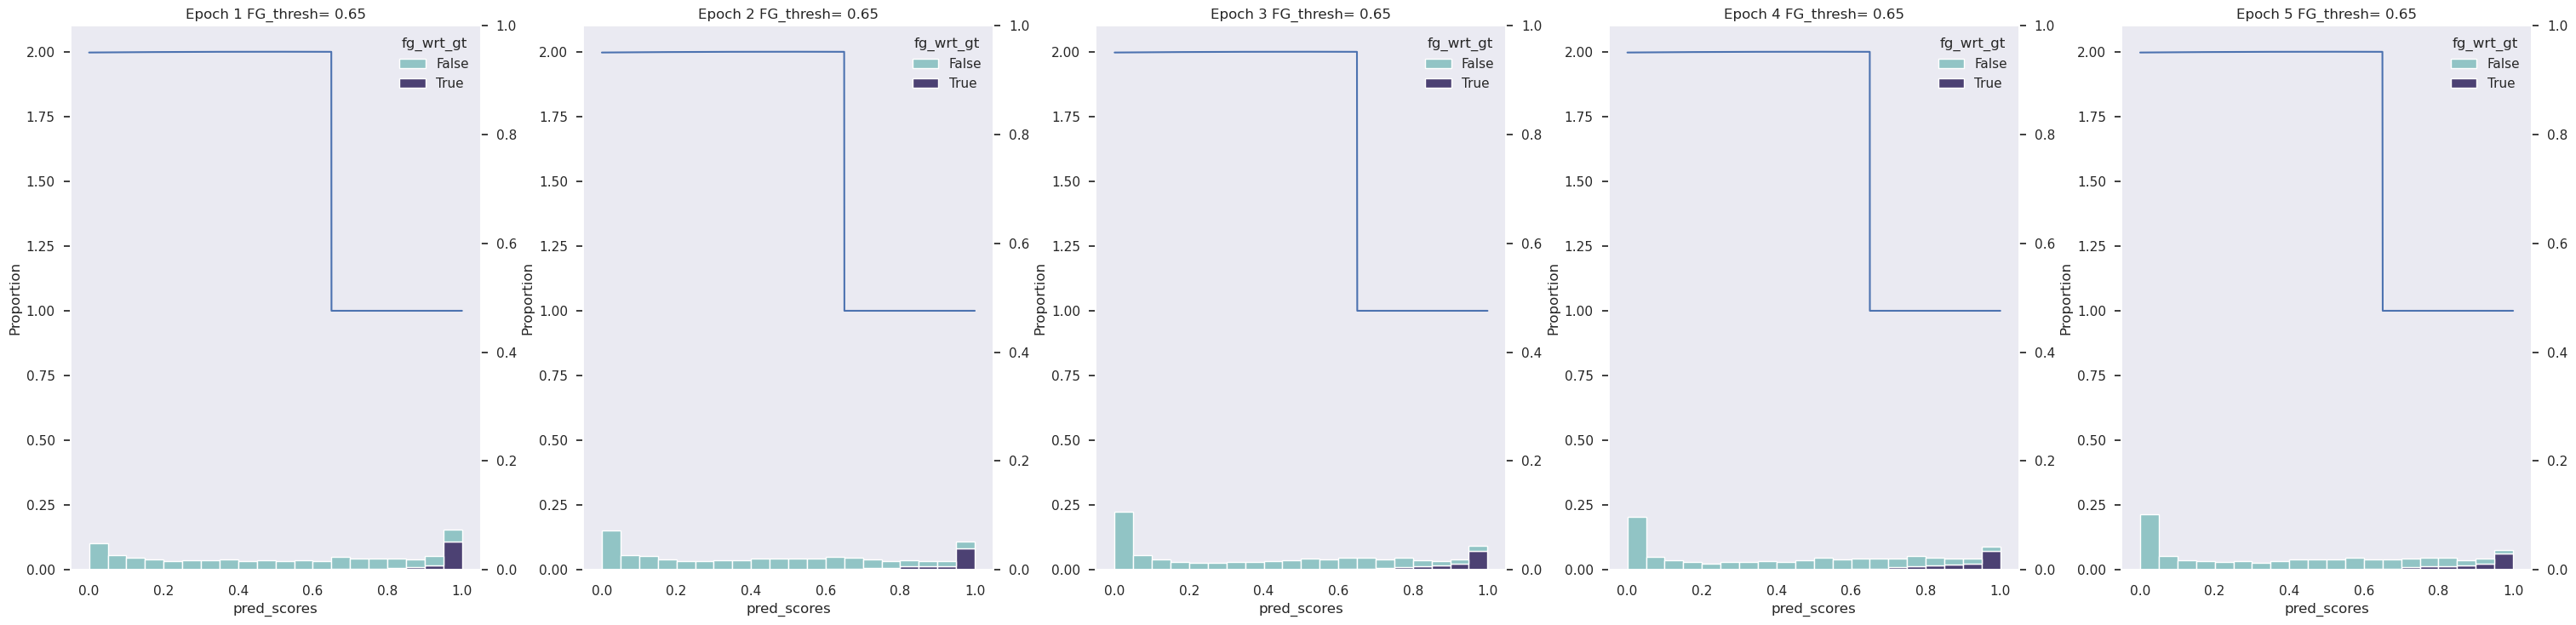

In [82]:
def plot_epoch_with_gaussian(grouped_df,start,end):
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='dark')
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    for i in range(start,end):
        # sns.histplot(ax=axes[0],data=grouped_ot_iou_df.get_group(float(i)),x='iou_roi_pl',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,legend=True,palette=palette,alpha=1.0)
        sns.histplot(ax=axes[i-start],data=grouped_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,palette=palette,alpha=1.0)
        sns.lineplot(ax=axes[i-start],x=grouped_df.get_group(float(i))['pred_scores'],y=grouped_df.get_group(float(i))['gaussian'])
        axes[i-start].set_title(f'Epoch {i} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[i-start].twinx()
        ax2.set_ylim(0, 1)
    plt.show()
plot_epoch_with_gaussian(grouped_ot_iouweights_df,1,6)

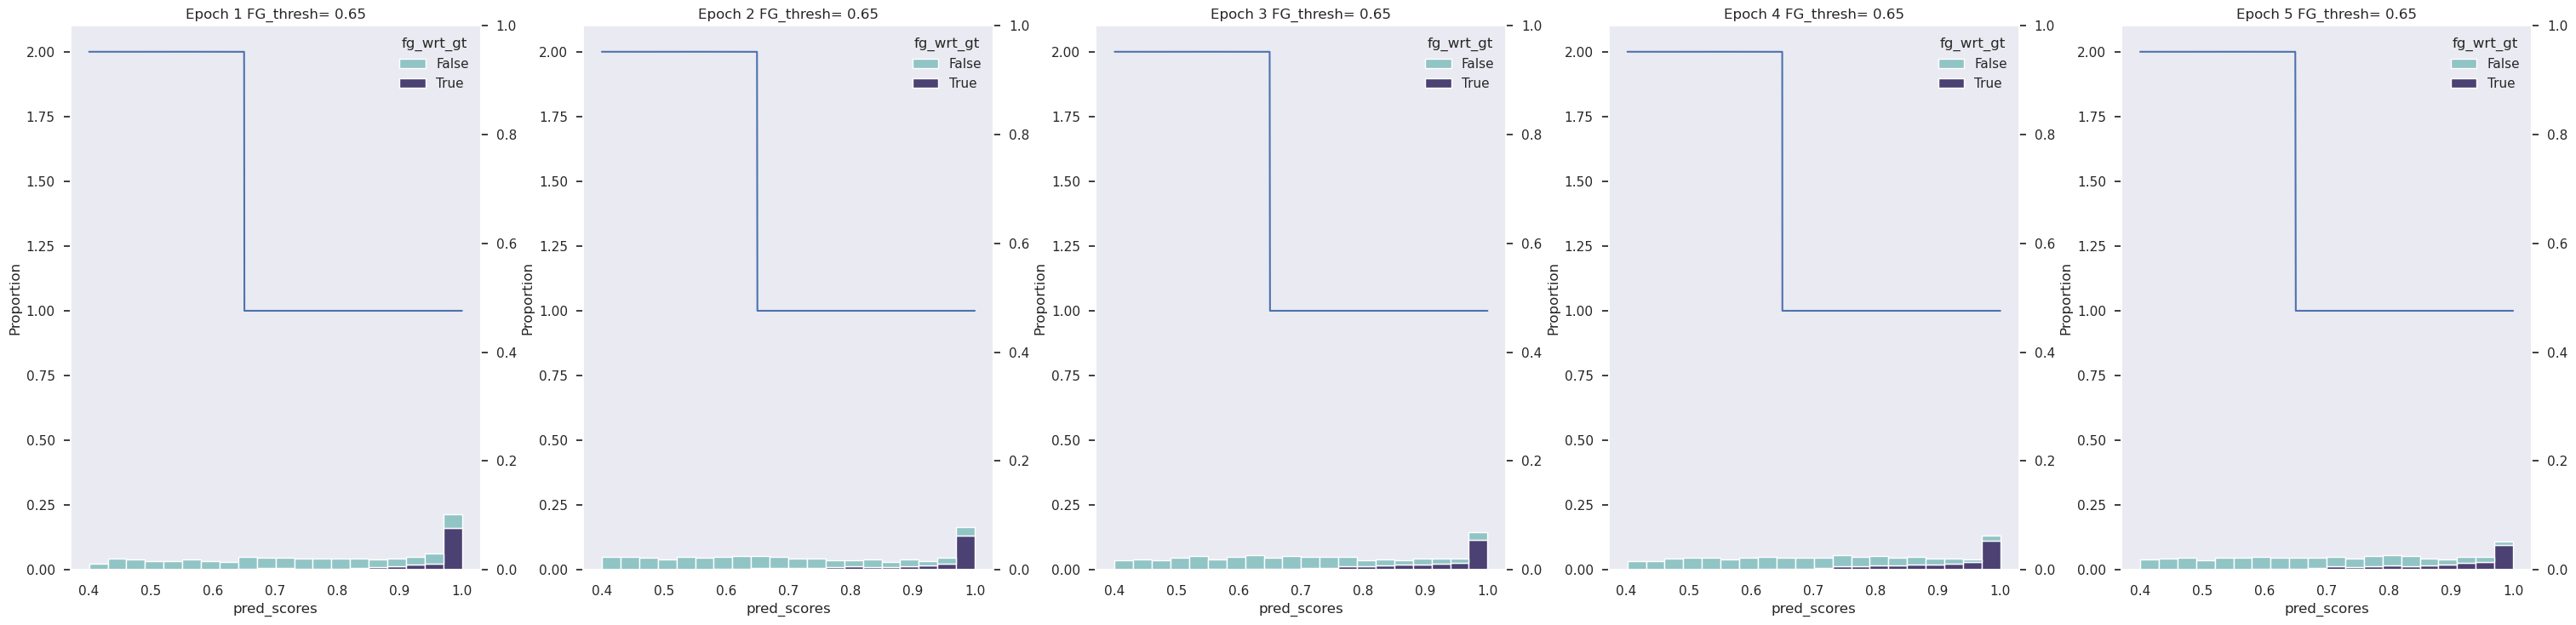

In [83]:
plot_epoch_with_gaussian(grouped_thresh_df,1,6)

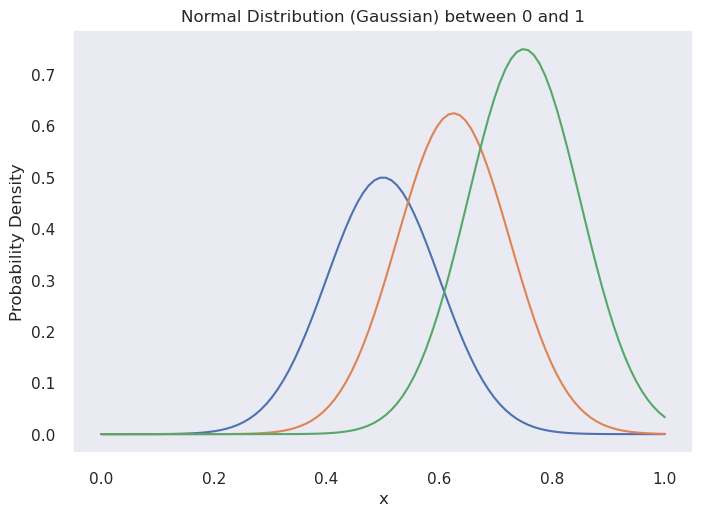

In [165]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)


def gaussian_plot(x, mu, sigma):
    """
    Calculate the Gaussian probability density function (PDF) for a given input x,
    mean mu, and standard deviation sigma.
    
    Args:
        x (float or array-like): Input value(s) for which to calculate the PDF.
        mu (float): Mean of the Gaussian distribution.
        sigma (float): Standard deviation of the Gaussian distribution.
    
    Returns:
        float or ndarray: The probability density value(s) for the given input(s) x.
    """
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    coefficient = mu
    return coefficient * np.exp(exponent)

# Generate x values
x = np.linspace(0, 1, 100)
means = np.linspace(0.5,0.75,3)

# Mean and standard deviation of the Gaussian distribution
mu = 0.5
sigma = 0.1
for mu in means:
    pdf = gaussian_plot(x, mu, sigma)
    plt.plot(x, pdf,label=f"Mean = {mu}")

# Set plot title and labels
plt.title('Normal Distribution (Gaussian) between 0 and 1')
plt.xlabel('x')
plt.ylabel('Probability Density')

# Display the plot
plt.show()

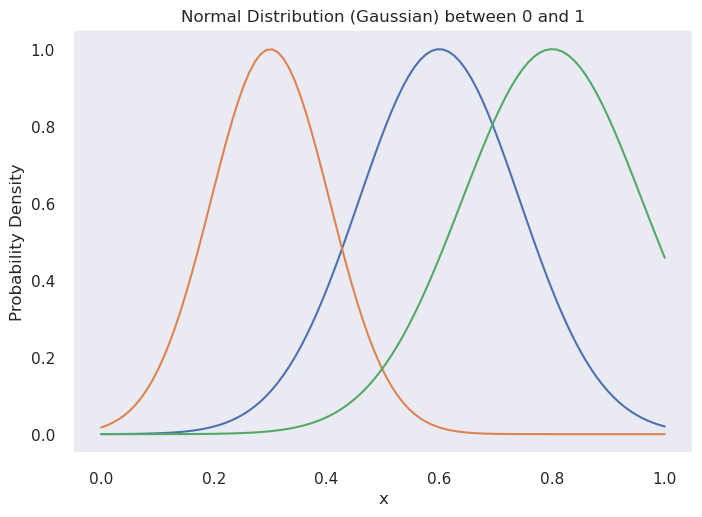

In [209]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)


def gaussian_plot(x, mu, sigma):
    exponent = -0.5 * ((x - mu) / sigma) ** 2 / (mu*(4-mu))
    coefficient = 1 
    return coefficient * np.exp(exponent)

# Generate x values
x = np.linspace(0, 1, 100)
means = np.array([0.6,0.3,0.8])

# Mean and standard deviation of the Gaussian distribution
mu = 0.5
sigma = 0.1
for mu in means:
    pdf = gaussian_plot(x, mu, sigma)
    plt.plot(x, pdf,label=f"Mean = {mu}")

# Set plot title and labels
plt.title('Normal Distribution (Gaussian) between 0 and 1')
plt.xlabel('x')
plt.ylabel('Probability Density')

# Display the plot
plt.show()

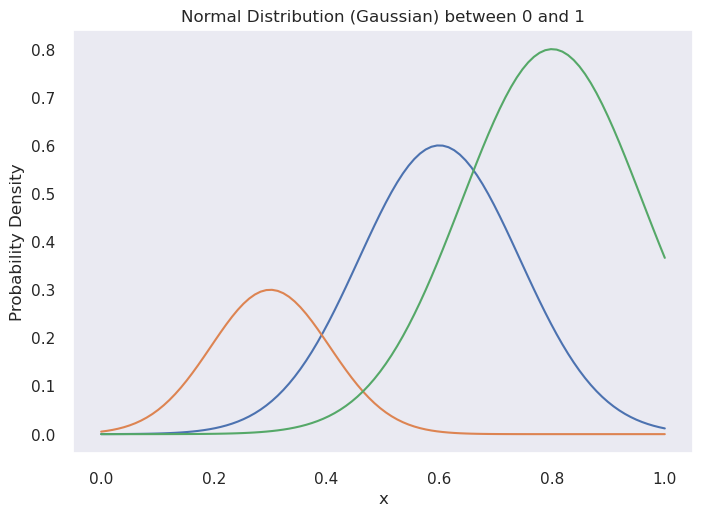

In [210]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)


def gaussian_plot(x, mu, sigma):
    exponent = -0.5 * ((x - mu) / sigma) ** 2 / (mu*(4-mu))
    coefficient = mu 
    return coefficient * np.exp(exponent)

# Generate x values
x = np.linspace(0, 1, 100)
means = np.array([0.6,0.3,0.8])

# Mean and standard deviation of the Gaussian distribution
mu = 0.5
sigma = 0.1
for mu in means:
    pdf = gaussian_plot(x, mu, sigma)
    plt.plot(x, pdf,label=f"Mean = {mu}")

# Set plot title and labels
plt.title('Normal Distribution (Gaussian) between 0 and 1')
plt.xlabel('x')
plt.ylabel('Probability Density')

# Display the plot
plt.show()

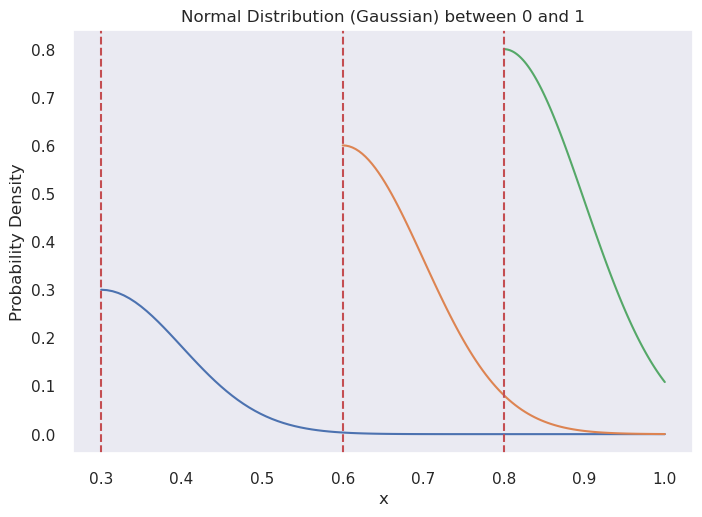

In [244]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)


def gaussian_plot(x, mu, sigma):
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    coefficient = mu
    return (coefficient * np.exp(exponent))

# Generate x values

means = np.array([0.3,0.6,0.8])

# Mean and standard deviation of the Gaussian distribution
mu = 0.5
sigma = 0.1
for mu in means:
    x = np.linspace(mu, 1.0, 100)
    pdf = gaussian_plot(x, mu, sigma)
    plt.plot(x, pdf,label=f"Mean = {mu}")
    plt.axvline(x=mu, color='r', linestyle='--', label='Vertical Line at x=1')
# Set plot title and labels
plt.title('Normal Distribution (Gaussian) between 0 and 1')
plt.xlabel('x')
plt.ylabel('Probability Density')

# Display the plot
plt.show()